# Прогнозирование температуры сплава в рамках мероприятий по уменьшению потребления электроэнергии на металлургическом комбинате

## Резюме исследования

**Заголовок:** Прогнозирование температуры сплава

**Описание проекта:** Комбинат собрал исторические данные о производственном процессе обработки стали. Чтобы уменьшить потребление электроэнергии на этапе обработки стали, нужно спрогнозировать температуру сплава после цикла обработки стали. Необходимо построить модель для такого предсказания.

**Критерии, которые важны заказчику:**
Значение метрики *MAE* на тестовой выборке должно быть не больше 6.8.

**Цель исследования:** 
1. Спрогнозировать температуру сплава после цикла обработки стали.

**Ход исследования:**
* Загрузка датасета и анализ общей информации
* Предобработка данных: выявление дубликатов, преобразование аномальных значений, корректировка типов данных
* Исследовательский анализ данных (ИАД): анализ количественных и категориальных признаков, корреляционный анализ признаков
* Трансформация признаков и повторный ИАД
* Формирование пайплайна и обучение моделей регрессии (**таргет - температура сплава после цикла обработки стали**), оценка их качества

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов

## Импорт библиотек

In [1]:
!pip install phik -q
!pip install numpy==1.22.4 -q
!pip install matplotlib==3.5.3 -q
!pip install catboost -q
!pip install shap -q

In [2]:
# Импортируем библиотеки для работы над проектом

import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik
import lightgbm as lgb
import sklearn
import time
import shap

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.utils.fixes")

# загружаем библиотеки для проверки признаков на мультиколлениарность
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score

# загружаем библиотеку анализа важности признаков
from sklearn.inspection import permutation_importance


# загружаем классы для подготовки данных
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# Загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Загружаем метрики
from sklearn.metrics import mean_absolute_error

# загружаем функцию для копирования параметров модели без обученных весов
from sklearn.base import clone

from sklearn.dummy import DummyRegressor

from numpy.random import RandomState

# Задаём настройки для разделения выборки
RANDOM_STATE = 120126
TEST_SIZE = 0.25

# Устанавливаем размер для всех графиков
plt.rcParams['figure.figsize'] = (8, 6);

# Настройка отображения
pd.set_option('display.max_columns', None)  # Все столбцы
pd.set_option('display.width', None)        # Ширина отображения
pd.set_option('display.max_colwidth', None)   # Максимальная ширина столбца
pd.set_option('display.float_format', '{:.2f}'.format)  # Формат чисел

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


## Загрузка данных

In [3]:
# Базовые пути
BASE_URL = "https://code.s3.yandex.net/datasets"
LOCAL_PATH = Path("/datasets")

# Описание датасетов
DATASETS = {
    "data_arc": "data_arc_new.csv",
    "data_bulk": "data_bulk_new.csv",
    "data_bulk_time": "data_bulk_time_new.csv",
    "data_gas": "data_gas_new.csv",
    "data_temp": "data_temp_new.csv",
    "data_wire": "data_wire_new.csv",
    "data_wire_time": "data_wire_time_new.csv",
}

# Контейнер для загруженных датафреймов
datasets: dict[str, pd.DataFrame] = {}

for name, filename in DATASETS.items():
    try:
        # Попытка загрузки по URL
        datasets[name] = pd.read_csv(f"{BASE_URL}/{filename}")
        print(f"{name}: загружен из удалённого источника")
    except Exception as e:
        try:
            # Фолбэк: загрузка из локальной папки
            datasets[name] = pd.read_csv(LOCAL_PATH / filename)
            print(f"{name}: загружен из локальной папки")
        except Exception as e_local:
            print(f"{name}: не удалось загрузить ни из URL, ни локально")
            raise e_local

data_arc: загружен из удалённого источника
data_bulk: загружен из удалённого источника
data_bulk_time: загружен из удалённого источника
data_gas: загружен из удалённого источника
data_temp: загружен из удалённого источника
data_wire: загружен из удалённого источника
data_wire_time: загружен из удалённого источника


## Общая информация по датасету

In [4]:
# Воспользуемся циклом для ознакомления с датасетами
for df_name, df in datasets.items():
    print(df_name)
    display(df.head())
    print('=' * 20)

data_arc


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64


data_bulk


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,150.00,154.00
1,2,NaN,NaN,NaN,73.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,149.00,154.00
2,3,NaN,NaN,NaN,34.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.00,NaN,152.00,153.00
3,4,NaN,NaN,NaN,81.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.00,NaN,153.00,154.00
4,5,NaN,NaN,NaN,78.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.00,NaN,151.00,152.00


data_bulk_time


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


data_gas


,key,Газ 1
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41


data_temp


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.00
1,1,2019-05-03 11:07:18,1604.00
2,1,2019-05-03 11:11:34,1618.00
3,1,2019-05-03 11:18:04,1601.00
4,1,2019-05-03 11:25:59,1606.00


data_wire


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.24,9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


data_wire_time


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Воспользуемся циклом для вывода общей информации по датасетам
for df_name, df in datasets.items():
    print(df_name, "\n")
    display(df.info())
    print('=' * 20)

data_arc 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

data_bulk 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

data_bulk_time 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

data_gas 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

data_temp 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

data_wire 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

data_wire_time 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

### Промежуточные выводы

**Общая информация:**
* data_arc: 4 признака, 14 876 строк, без пропущенных значений, необходимо скорректировать тип данных для временных признаков
* data_bulk, data_bulk_time: 15 признаков, 3 129 строк, есть пропущенные значения
* data_gas: 1 признак, 3 239 строк, без пропущенных значений
* data_temp: 2 признака, 18 092 строки, есть пропущенные значения
* data_wire, data_wire_time: 9 признаков, 3 081 строка, есть пропущенные значения


* Необходимо скорректировать тип данных для временных признаков в датасетах:
    * data_arc
    * data_bulk_time
    * data_temp
    * data_wire_time
  
* Приведем наименования признаков к виду snake_case для удобства анализа
* Переведем имена признаков на латинские буквы

## Предобработка данных

### Приведение имен признаков к единому виду

In [6]:
# Приведём имена столбцов к типу snake_case
for df_name, df in datasets.items():
    df.columns = df.columns.str.replace(" ", "_").str.lower()
    print(name, "\n")
    display(df.columns)
    print("*" * 10, "\n")

data_wire_time 



Index(['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой',
       'активная_мощность', 'реактивная_мощность'],
      dtype='object')

********** 

data_wire_time 



Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

********** 

data_wire_time 



Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

********** 

data_wire_time 



Index(['key', 'газ_1'], dtype='object')

********** 

data_wire_time 



Index(['key', 'время_замера', 'температура'], dtype='object')

********** 

data_wire_time 



Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

********** 

data_wire_time 



Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

********** 



In [7]:
# Создаем словарь для переименования колонок
column_translations = {
    "data_arc": {
        "начало_нагрева_дугой":"arc_heating_start",
        "конец_нагрева_дугой":"arc_heating_end",
        "активная_мощность":"active_power",
        "реактивная_мощность":"reactive_power"
    },
    
    "data_gas": {
        "газ_1":"gas_1",
    },
    
    "data_temp": {
        "время_замера":"measurement_time",
        "температура":"temperature"
    },
}

In [8]:
# Используем цикл для переименования столбцов
for name, df in datasets.items():
    if name in column_translations:
        df.rename(columns=column_translations[name], inplace=True)
        
        print(name, "\n")
        display(df.columns)
        print("*" * 10, "\n")

data_arc 



Index(['key', 'arc_heating_start', 'arc_heating_end', 'active_power',
       'reactive_power'],
      dtype='object')

********** 

data_gas 



Index(['key', 'gas_1'], dtype='object')

********** 

data_temp 



Index(['key', 'measurement_time', 'temperature'], dtype='object')

********** 



### Корректировка типов данных

In [9]:
# Создаем словарь для переименования колонок
datetime_columns = {
    "data_arc": ["arc_heating_start", "arc_heating_end"],
    "data_temp": ["measurement_time"],
    "data_bulk_time": ["bulk_1", "bulk_2", "bulk_3", "bulk_4", "bulk_5", "bulk_6", "bulk_7", "bulk_8", 
                       "bulk_9", "bulk_10", "bulk_11", "bulk_12", "bulk_13", "bulk_14", "bulk_15"],
    "data_wire_time": ["wire_1", "wire_2", "wire_3", "wire_4", "wire_5", "wire_6", "wire_7", "wire_8", "wire_9"]
}

In [10]:
# Воспользуемся циклом для корректировки временных признаков
for name, df in datasets.items():
    if name in datetime_columns:
        for col in datetime_columns[name]:
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    print(name, "\n")
    display(df.info())
    print("*" * 10, "\n")

data_arc 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   arc_heating_start  14876 non-null  datetime64[ns]
 2   arc_heating_end    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

********** 

data_bulk 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

********** 

data_bulk_time 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 39

None

********** 

data_gas 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

********** 

data_temp 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               18092 non-null  int64         
 1   measurement_time  18092 non-null  datetime64[ns]
 2   temperature       14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

********** 

data_wire 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

********** 

data_wire_time 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

********** 



### Пропущенные значения

In [11]:
# Воспользуемся циклом для просмотра пропущенных значений в датасетах
for df_name, df in datasets.items():
    print(df_name, "\n")
    display(df.isna().sum())
    print('=' * 20)

data_arc 



key                  0
arc_heating_start    0
arc_heating_end      0
active_power         0
reactive_power       0
dtype: int64

data_bulk 



key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

data_bulk_time 



key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

data_gas 



key      0
gas_1    0
dtype: int64

data_temp 



key                    0
measurement_time       0
temperature         3427
dtype: int64

data_wire 



key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

data_wire_time 



key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

### Подсчёт явных дубликатов

In [12]:
# Воспользуемся циклом для просмотра явных дубликатов в датасетах
for name, df in datasets.items():
    print(name, "\n")
    display(df.duplicated().sum())
    print('=' * 20)

data_arc 



0

data_bulk 



0

data_bulk_time 



0

data_gas 



0

data_temp 



0

data_wire 



0

data_wire_time 



0

Явные дубликаты отсутствуют

### Подсчет уникальных ключей в датасетах

In [13]:
# Воспользуемся циклом для просмотра пропущенных значений в датасетах
for df_name, df in datasets.items():
    print(df_name, "\n")
    print("Количество дубликатов по ключам:")
    display(df["key"].duplicated().sum())
    print("Количество уникальных ключей:")
    display(df["key"].nunique())
    print('=' * 20)

data_arc 

Количество дубликатов по ключам:


11662

Количество уникальных ключей:


3214

data_bulk 

Количество дубликатов по ключам:


0

Количество уникальных ключей:


3129

data_bulk_time 

Количество дубликатов по ключам:


0

Количество уникальных ключей:


3129

data_gas 

Количество дубликатов по ключам:


0

Количество уникальных ключей:


3239

data_temp 

Количество дубликатов по ключам:


14876

Количество уникальных ключей:


3216

data_wire 

Количество дубликатов по ключам:


0

Количество уникальных ключей:


3081

data_wire_time 

Количество дубликатов по ключам:


0

Количество уникальных ключей:


3081

### Промежуточные выводы

* Имена признаков приведены к виду snake_case и переведены на английский язык
* Тип данных временных признаков приведен в соответствие
* Явные дубликаты отсутствуют
* Выявлены пропущенные значения - к обработке после объединения датасетов

## Исследовательский анализ данных

### Описательная статистика признаков

In [14]:
# Воспользуемся циклом для просмотра статистик числовых переменных
for name, df in datasets.items():
    print(name, "\n")
    display(df.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.97, 0.99]))
    print('=' * 20)

data_arc 



,key,active_power,reactive_power
count,14876.00,14876.00,14876.00
mean,1615.22,0.66,0.44
std,934.57,0.26,5.87
min,1.00,0.22,-715.48
25%,806.00,0.47,0.34
50%,1617.00,0.60,0.44
75%,2429.00,0.83,0.61
95%,3072.00,1.18,0.88
97%,3138.00,1.24,0.93
99%,3205.00,1.34,1.03


data_bulk 



,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.00,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,1.00,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,1624.38,39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.00,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,933.34,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,1.00,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.00,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,816.00,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.00,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,1622.00,31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.00,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,2431.00,46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.00,70.50,102.00,106.00,316.00,203.50,205.75,205.00
95%,3080.60,73.00,281.40,264.00,192.00,235.60,261.25,571.40,49.00,114.60,124.25,200.00,466.00,282.05,298.00,224.00
97%,3143.16,80.35,297.91,291.09,213.22,252.08,283.75,630.88,49.00,127.56,126.00,205.72,512.00,291.23,310.85,227.00
99%,3208.72,98.90,315.97,343.18,239.00,367.40,351.75,724.96,49.00,140.52,148.75,229.84,570.00,300.41,374.80,240.00


data_bulk_time 



,key
count,3129.00
mean,1624.38
std,933.34
min,1.00
25%,816.00
50%,1622.00
75%,2431.00
95%,3080.60
97%,3143.16
99%,3208.72


data_gas 



,key,gas_1
count,3239.00,3239.00
mean,1621.86,11.00
std,935.39,6.22
min,1.00,0.01
25%,812.50,7.04
50%,1622.00,9.84
75%,2431.50,13.77
95%,3079.10,22.63
97%,3143.86,25.29
99%,3208.62,31.56


data_temp 



,key,temperature
count,18092.00,14665.00
mean,1616.46,1590.72
std,934.64,20.39
min,1.00,1191.00
25%,807.75,1580.00
50%,1618.00,1590.00
75%,2429.00,1599.00
95%,3073.00,1623.00
97%,3139.00,1633.00
99%,3206.00,1651.00


data_wire 



,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.00,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,1623.43,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,1619.00,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,2434.00,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
95%,3085.00,171.54,128.71,292.71,106.60,15.13,107.61,22.60,96.00,63.04
97%,3146.60,185.18,143.84,311.88,109.25,15.13,134.43,26.70,98.70,67.37
99%,3210.20,209.27,181.31,349.19,111.91,15.13,155.03,30.80,101.41,82.49


data_wire_time 



,key
count,3081.00
mean,1623.43
std,933.00
min,1.00
25%,823.00
50%,1619.00
75%,2434.00
95%,3085.00
97%,3146.60
99%,3210.20


* В датасете data_arc обнаружена аномалия в столбце `reactive_power` - энергия не может быть отрицательной, необходимо её обработать
* Встречаются признаки с малым количеством наблюдений (менее 100):
    * `data_bulk`: bulk_2, bulk_5, bulk_7, **bulk_8 (1 наблюдение)**, bulk_9, bulk_13
    * `data_wire`: wire_3, wire_4, **wire_5 (1 наблюдение)**, wire_7, wire_8, wire_9
* Признаки bulk_8, wire_5 являются константными и их можно исключить из анализа и не передавать в модель

###  Обработка аномальных значений признаков

#### Признак `reactive_power`

In [15]:
# Инициализация датасета
data_arc = datasets["data_arc"]

# Посмотрим, есть ли аналогичные аномалии у признака реактивной мощности
data_arc.loc[data_arc["reactive_power"] < 0]

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.71,-715.48


In [16]:
# Маска для удобной обработки
mask = data_arc["reactive_power"] < 0

# Обработаем эту аномалию: уберем минус и разделим на 1 000
data_arc.loc[mask, "reactive_power"] = (data_arc.loc[mask, "reactive_power"] / 1000 * (-1))

In [17]:
# Проверяем результат обработки
data_arc.loc[data_arc["reactive_power"] < 0]

,key,arc_heating_start,arc_heating_end,active_power,reactive_power


#### Признак `temperature`

Температура ниже 1300 градусов является аномалией технологического производства стали, необходимо изучить количество таких аномалий и отфильтровать их из дальнейшего исследования

In [18]:
# Инициализация датасета
data_temp = datasets["data_temp"]

# Посмотрим, сколько наблюдений с аномальной температурой менее 1300 градусов
data_temp.loc[data_temp["temperature"] < 1300]

,key,measurement_time,temperature
4883,867,2019-06-06 08:03:39,1191.00
6784,1214,2019-06-18 08:01:03,1208.00
9050,1619,2019-07-03 02:34:41,1218.00
11495,2052,2019-07-25 08:49:15,1227.00
14283,2561,2019-08-12 18:49:29,1204.00


In [19]:
# Отфильтруем эти значения из датасета
data_temp = data_temp.loc[data_temp["temperature"] >= 1300].copy()

# Смотрим на результат фильтрации
data_temp.loc[data_temp["temperature"] < 1300]

,key,measurement_time,temperature


Аномальные температуры исключены из дальнейшего исследования

### Внесение изменений в датасеты с учетом обработки аномальных значений

In [20]:
# Инициализация датасетов
data_bulk = datasets["data_bulk"]
data_wire = datasets["data_wire"]
data_gas = datasets["data_gas"]
data_bulk_time = datasets["data_bulk_time"]
data_wire_time = datasets["data_wire_time"]

# Внесем изменение в словарь датасетов
datasets = {
    "data_arc": data_arc,
    "data_bulk": data_bulk,
    "data_bulk_time": data_bulk_time,
    "data_gas": data_gas,
    "data_temp": data_temp,
    "data_wire": data_wire,
    "data_wire_time": data_wire_time,
}

### Диаграммы размаха

In [21]:
# Пишем функцию для отрисовки диаграммы размаха
def plot_boxplot(
    df,
    column,
    dataset_name=None,
    whis=3,
    figsize=(5,3)
):
    """Функция для отрисовки диаграмма размаха:
    - принимает на вход: датафрейм, столбец для отрисовки, имя датафрейма, размер графика
    - отрисовывает диаграмму размаха"""

    # Устанавливаем размер и вид графика
    plt.figure(figsize=figsize)
    sns.boxplot(y=df[column], whis=whis)

    # Определяем наименование графика
    title = f"Диаграмма размаха: {column}"
    if dataset_name:
        title += f" | {dataset_name}"

    # Выводим график и подписи на экран
    plt.title(title)
    plt.ylabel(column)
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

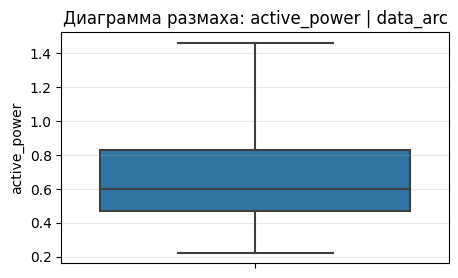

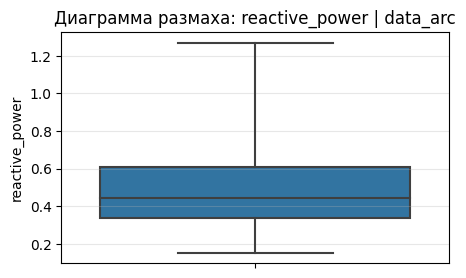

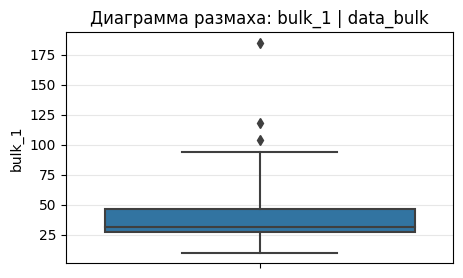

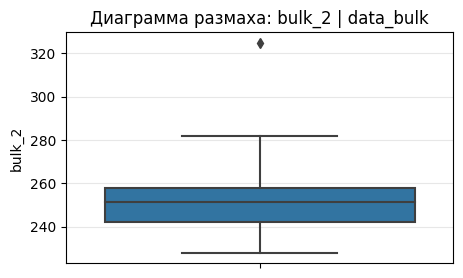

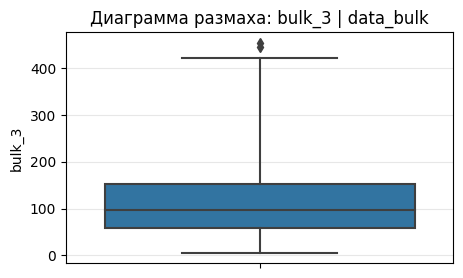

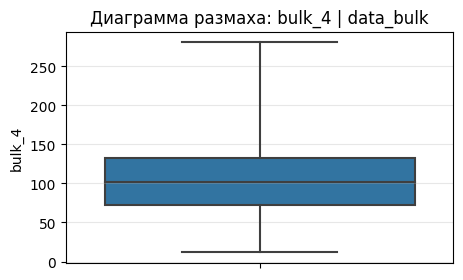

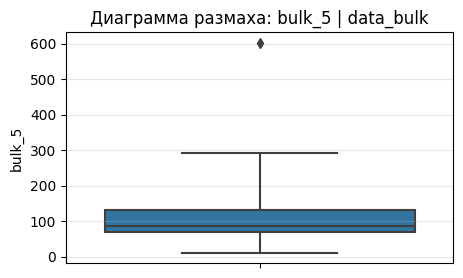

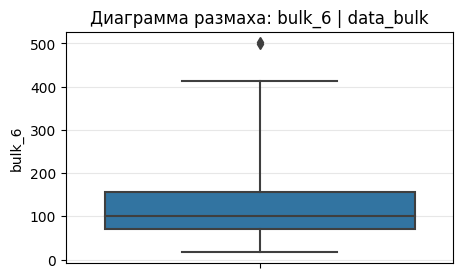

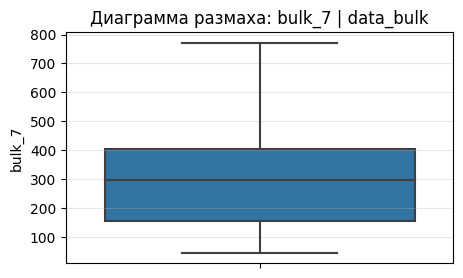

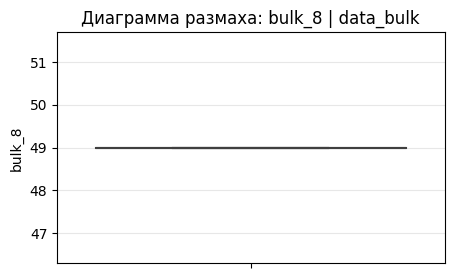

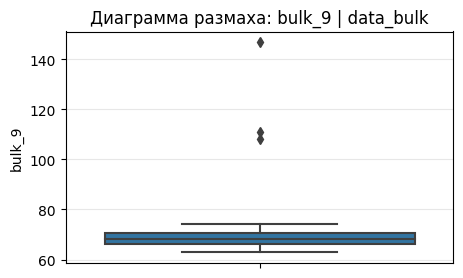

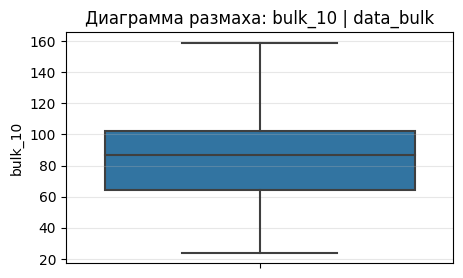

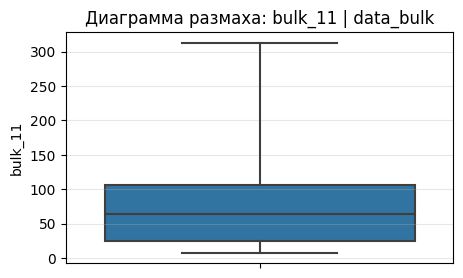

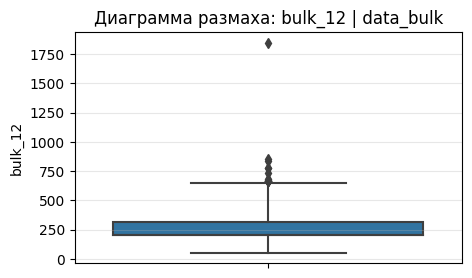

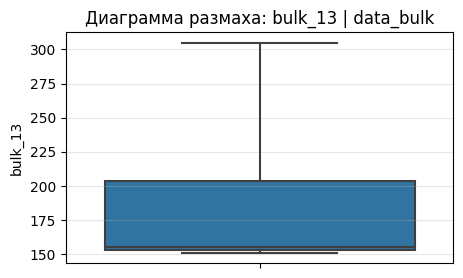

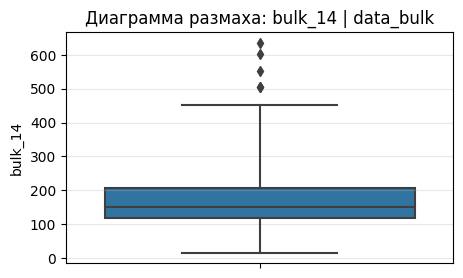

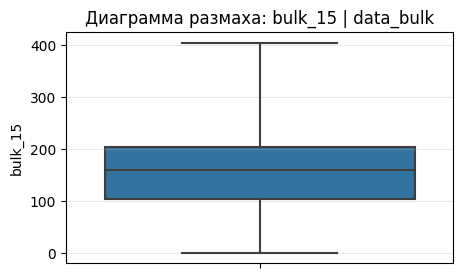

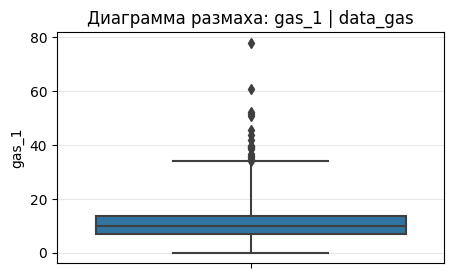

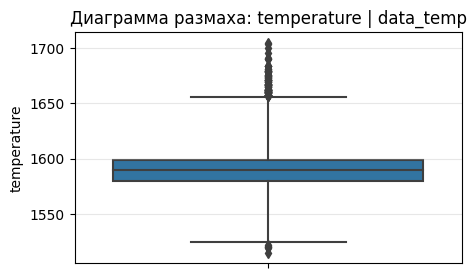

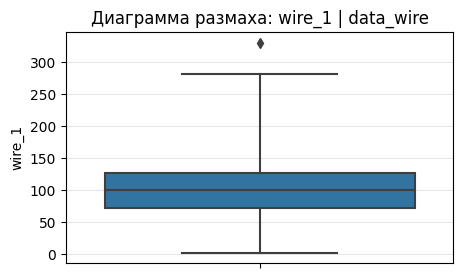

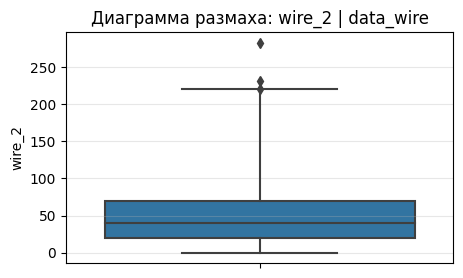

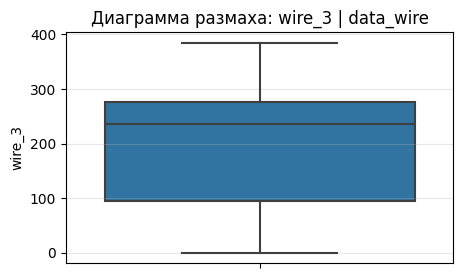

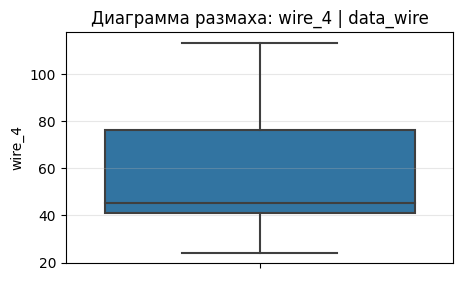

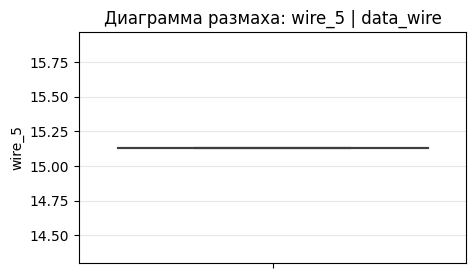

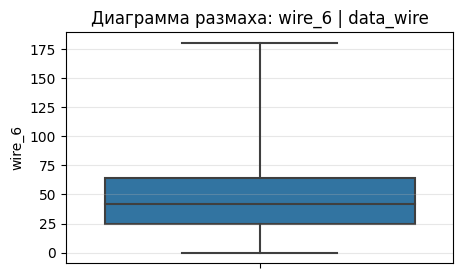

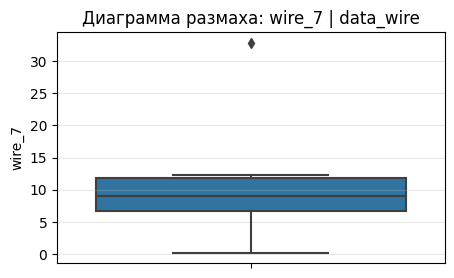

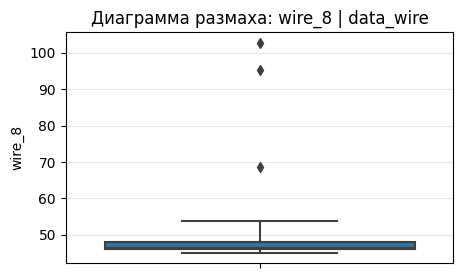

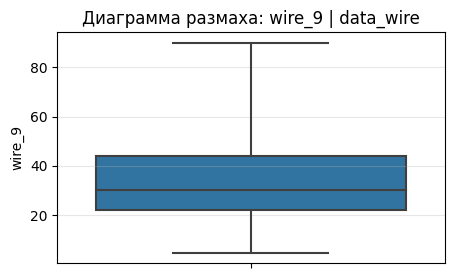

In [22]:
# Воспользуемся циклом для отрисовки графика
for name, df in datasets.items():
    df_key_off = df.drop(columns=['key']).copy() # Удаляем столбец с ключами
    numeric_cols = df_key_off.select_dtypes(include="number").columns # Выбираем только признаки с числовым типом данных

    # Цикл по столбцам
    for col in numeric_cols:
        plot_boxplot(
            df=df_key_off,
            column=col,
            dataset_name=name
        )

#### Комментарии к графику

* Есть выбросы:
    * в датасете `data_bulk` по признакам: bulk_1, bulk_2, bulk_3, bulk_5, bulk_6, bulk_9, bulk_12, bulk_14
    * в датасете `data_gas` по признаку gas_1
    * в датасете `data_temp` по признаку temperature (обработаны температуры ниже технологического порога в 1300 градусов)
    * в датасете `data_wire` по признакам wire_1, wire_2, wire_7, wire_8

--
* По некоторым признакам в датасетах встречается только одно уникальное значение:
    * в датасете `data_wire` по признаку wire_5
    * в датасете `data_bulk` по признакам bulk_8

--
* В целом перечисленные паттерны могут объясняться технологией изготовления разных марок стали, поэтому оставим выбросы без изменений

### Гистограммы

In [23]:
# Пишем функцию для отрисовки гистограммы
def plot_histogram(
    df,
    column,
    dataset_name=None,
    bins=30,
    figsize=(5,3)
):
    """Функция для отрисовки гистограммы:
    - принимает на вход: датафрейм, столбец для отрисовки, имя датафрейма, количество бинов
    - отрисовывает гистограмму"""

    # Размер график и его отрисовка
    plt.figure(figsize=figsize)
    sns.histplot(
        df[column],
        bins=bins,
        kde=False
    )

    # Имя графика
    title = f"Histogram: {column}"
    if dataset_name:
        title += f" | {dataset_name}"

    # Вывод графика на экран
    plt.title(title)
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

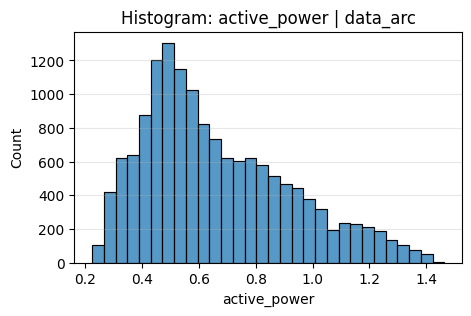

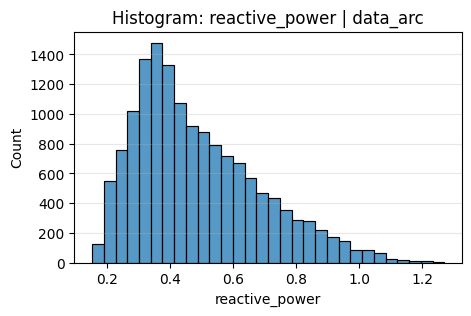

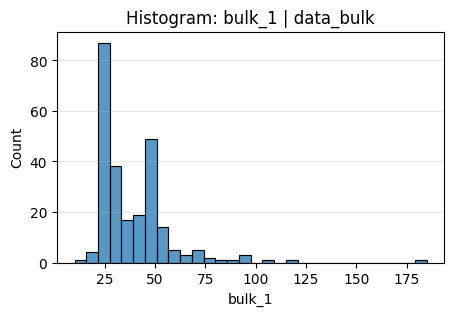

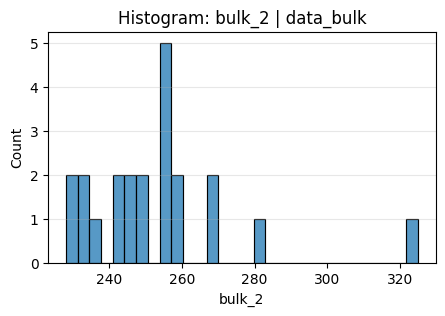

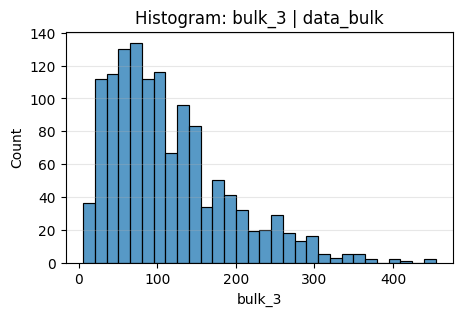

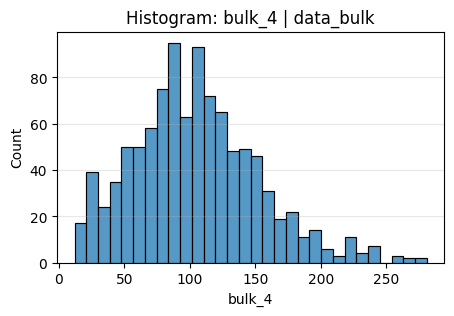

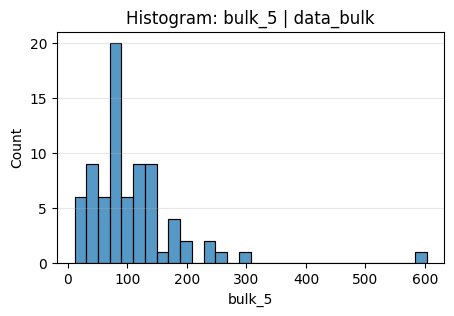

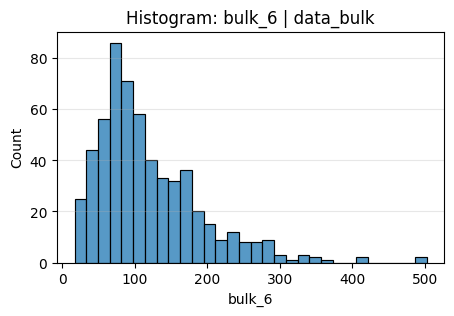

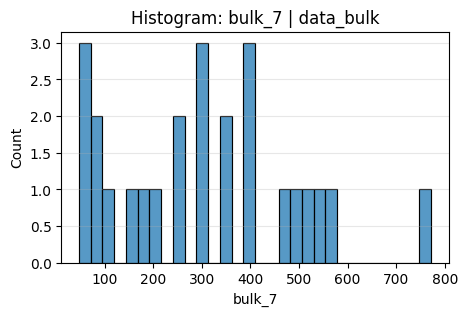

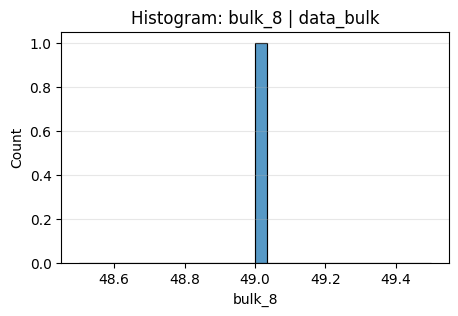

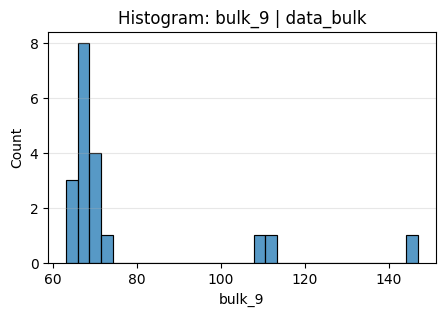

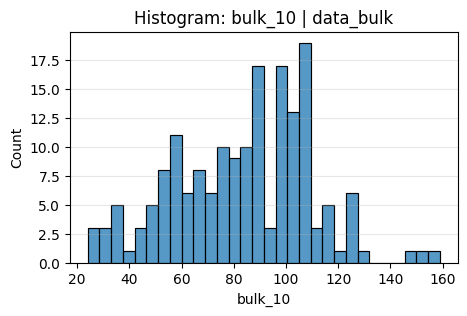

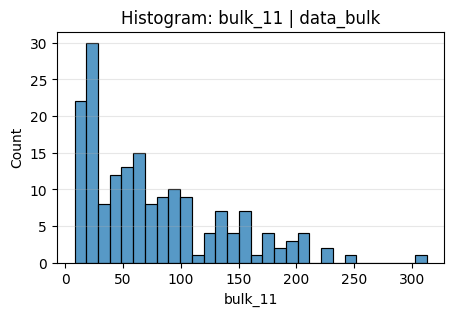

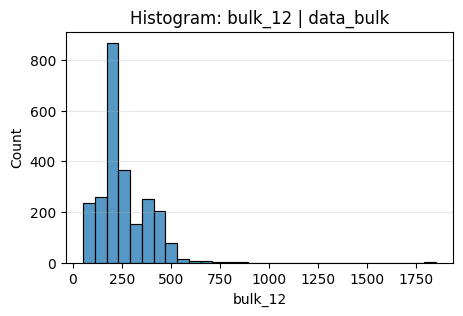

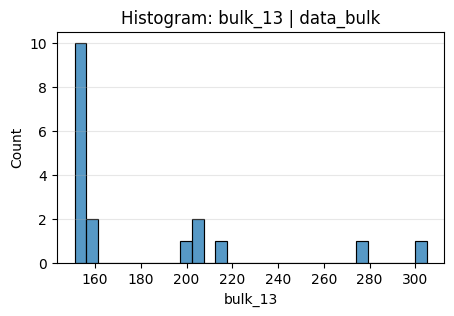

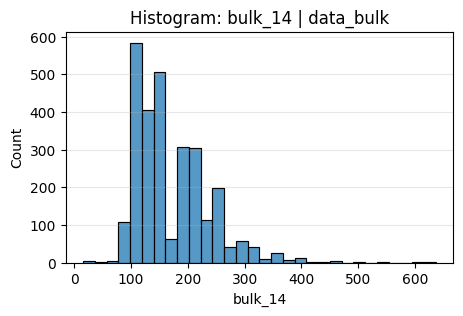

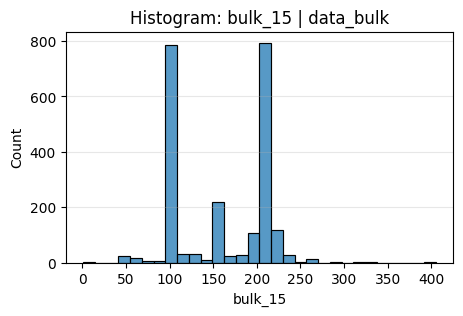

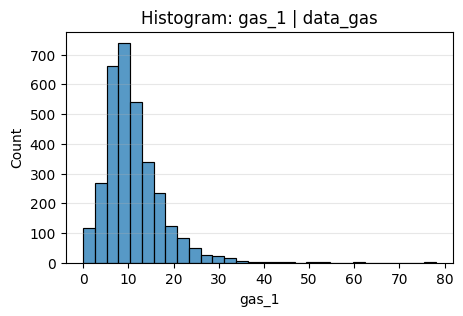

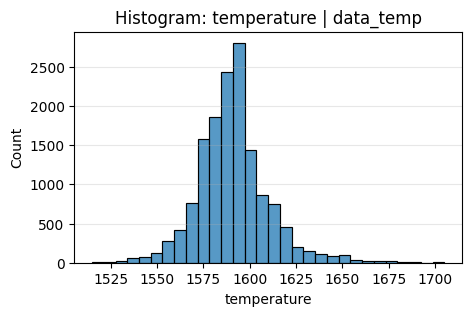

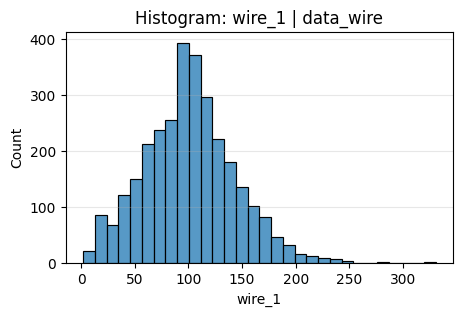

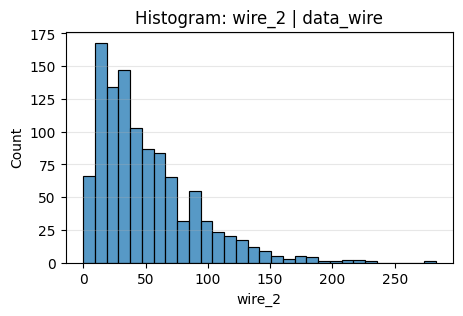

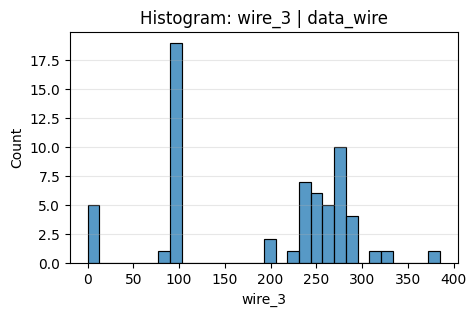

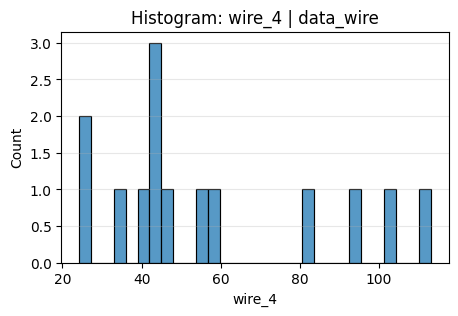

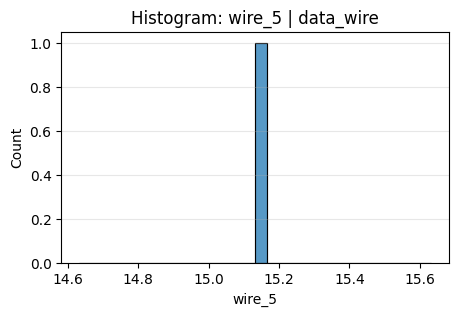

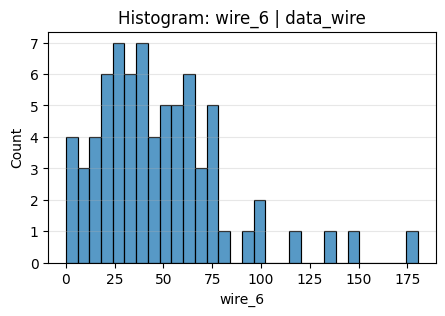

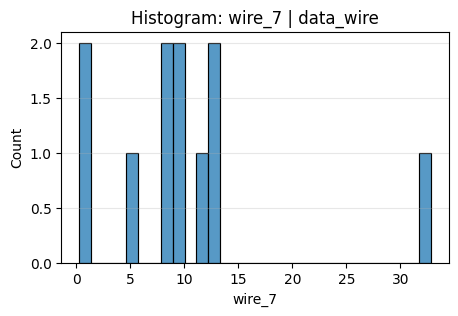

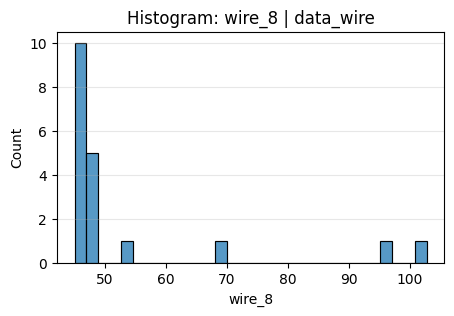

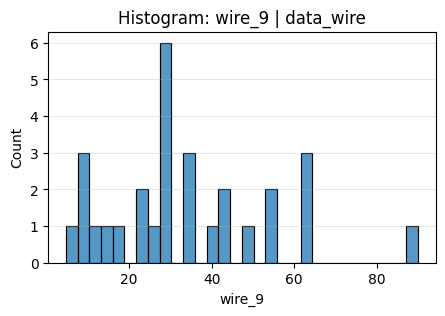

In [24]:
# Воспользуемся циклом для отрисовки гистограмм
for name, df in datasets.items():
    df_key_off = df.drop(columns=['key']).copy() # Удаляем столбец с ключами
    
    numeric_cols = df_key_off.select_dtypes(include="number").columns # Выбираем только признаки с числовым типом данных

    # Цикл по столбцам
    for col in numeric_cols:
        plot_histogram(
            df=df_key_off,
            column=col,
            dataset_name=name
        )

### Промежуточные выводы

* Аномальное отрицательное значение реактивной мощности обработано

* По датасету **`data_temp`** признак `temperature` непрерывный, узкий диапазон значений, одномодальный
* По датасету **`data_arc`** по признаками `active_power`, `reactive_power`
    * Выраженная правосторонняя асимметрия
    * Значимая вариативность
* По датасету **`data_bulk`** можем разделить признаки на следующие группы:
    * Количественные дозируемые (основные рабочие): `bulk_1`, `bulk_3`, `bulk_4`, `bulk_6`, `bulk_10`, `bulk_11`, `bulk_12`, `bulk_14`
        * Выраженная правосторонняя асимметрия
        * Значимая вариативность
    * Режимные (узкие по значениям): `bulk_2`
        * Очень мало наблюдений
    * Редкие дискретные с экстремальными режимами: `bulk_5`, `bulk_7`, `bulk_9`, `bulk_13`
        * Сильная разреженность
        * Мало ненулевых значений
    * Мультимодальные дозы: `bulk_15`
        * Чётко выраженные пики (примерно около значений 100 и 200)
        * Провал между режимами
    * Почти константные: `bulk_8` **(к удалению после объединения датасетов)**
* По датасету **`data_wire`** следующее распределение признаков:
    * Количественные признаки (асимметричные): `wire_1`, `wire_2`, `wire_6`
    * Мультимодальные (отчётливые пики, мало число наблюдений): `wire_3`
    * Редкие, разреженные: `wire_4`, `wire_7`, `wire_8`, `wire_9`
    * Почти константные: `wire_5` **(к удалению после объединения датасетов)**

## Объединение данных

### Трансформация признаков

#### Фильтрация признаков с недостаточным количеством замеров

* Учитывая то, что нам нужно предсказать крайний замер температуры, нет смысла работать с наблюдениями, где всего 1 замер (их должно быть минимум 2).
* Как будет фильтровать датасет:
    * Оставим только заполненные значения температуры
    * Оставим только записи, где ключ встречается минимум 2 раза

In [25]:
# Инициализация датасета
data_temp = datasets["data_temp"]

# Напоминаем информацию о датасете
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14660 non-null  int64         
 1   measurement_time  14660 non-null  datetime64[ns]
 2   temperature       14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.1 KB


In [26]:
# Оставляем наблюдения с наличием записи по температуре
data_temp_notna = data_temp.loc[data_temp["temperature"].notna()]

# Смотрим результат фильтрации
data_temp_notna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14660 non-null  int64         
 1   measurement_time  14660 non-null  datetime64[ns]
 2   temperature       14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.1 KB


In [27]:
# Посчитаем количество наблюдений в разрезе ключей
key_counts = data_temp_notna["key"].value_counts()

# Смотрим на значения
len(key_counts)

3215

In [28]:
# Посчитаем количество наблюдений с одним ключом
data_temp_notna.loc[data_temp_notna["key"].map(key_counts) == 1].count()

key                 740
measurement_time    740
temperature         740
dtype: int64

In [29]:
# Отфильтруем исходный датасет от ключей, по которым только 1 наблюдение
data_temp_filtered = data_temp_notna.loc[data_temp_notna["key"].map(key_counts) > 1]

# Проверяем результат
data_temp_filtered.loc[data_temp_filtered["key"].map(key_counts) < 2]

,key,measurement_time,temperature


In [30]:
# Сортируем датасет перед трансформацией
data_temp_filtered = data_temp_filtered.sort_values(by=["key", "measurement_time"])

# Смотрим на результат сортировки
data_temp_filtered.loc[data_temp_filtered["key"] == 1]

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.00
1,1,2019-05-03 11:07:18,1604.00
2,1,2019-05-03 11:11:34,1618.00
3,1,2019-05-03 11:18:04,1601.00
4,1,2019-05-03 11:25:59,1606.00
5,1,2019-05-03 11:30:38,1613.00


In [31]:
# Смотрим на общую информацию
data_temp_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13920 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               13920 non-null  int64         
 1   measurement_time  13920 non-null  datetime64[ns]
 2   temperature       13920 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.0 KB


#### Агрегация признаков `data_temp`

In [32]:
# Функция агрегации температур по определенным правилам
def aggregate_temperatures(group: pd.DataFrame) -> pd.Series:
    """
    * Функция принимает на вход датафрейм;
    * Формирует 2 списка: из наблюдений температур и наблюдений времён замера;
    * Выбирает первый замер как нулевой индекс списка;
    * Выбирает последний замер как последний индекс списка;
    * Считает медиану промежуточных замеров (без первого и последнего)
    * Возвращает обработанные столбцы: первый замер / промежуточный замер / крайний замер (температура и время)
    """
    temps = group["temperature"].values
    times = group["measurement_time"].values
    n = len(temps)

    T_first = temps[0]
    t_first = times[0]

    T_last = temps[-1]
    t_last = times[-1]

    # Логика расчета промежуточных замеров
    if n == 2:
        T_intermediate = 0
    elif n == 3:
        T_intermediate = temps[1]
    else:  # n >= 4
        T_intermediate = np.median(temps[1:-1])

    return pd.Series({
        "time_first": t_first,
        "temp_first": T_first,
        "time_last": t_last,
        "temp_last": T_last,                  # ← ТАРГЕТ
        "temp_intermediate": T_intermediate
    })

In [33]:
# Формируем конечный датафрейм по замерам
data_temp_target = (
    data_temp_filtered
    .groupby("key", as_index=False)
    .apply(aggregate_temperatures)
)

# Смотрим на результат
data_temp_target.head()

,key,time_first,temp_first,time_last,temp_last,temp_intermediate
0,1,2019-05-03 11:02:04,1571.00,2019-05-03 11:30:38,1613.00,1605.00
1,2,2019-05-03 11:34:04,1581.00,2019-05-03 11:55:09,1602.00,1589.00
2,3,2019-05-03 12:06:44,1596.00,2019-05-03 12:35:57,1599.00,1598.50
3,4,2019-05-03 12:39:27,1601.00,2019-05-03 12:59:47,1625.00,1618.00
4,5,2019-05-03 13:11:03,1576.00,2019-05-03 13:36:39,1602.00,1589.00


In [34]:
# Смотрим на общую информацию
data_temp_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2475 non-null   int64         
 1   time_first         2475 non-null   datetime64[ns]
 2   temp_first         2475 non-null   float64       
 3   time_last          2475 non-null   datetime64[ns]
 4   temp_last          2475 non-null   float64       
 5   temp_intermediate  2475 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 116.1 KB


#### Агрегация признаков `data_arc`

Последовательность шагов:

1. Объединяем датасет `data_arc` с конечным датафреймом замен `data_temp_target`.
2. Добавим новые столбцы:
    * effective_start - отражает время старта (= время старта нагрева дуги)
    * effective_end - отражает конечное время (минимальное из двух показателей - времени завершения нагрева дуги или последний замер температуры)
3. Посчитаем эффективное время нагрева: duration = effective_end - effective_start
4. Посчитаем энергию, полученную за эффективное время нагрева: energy = duration * active power
5. Агрегируем по ключу и суммируем показатели
6. Сформируем финальную таблицу

arc_active_energy_to_last
arc_total_duration_to_last
is_arc_active_at_last

In [35]:
# Объединяем датасет `data_arc` с конечным датафреймом замен `data_temp_target`
data_arc_temp = data_arc.copy()

data_arc_temp = data_arc_temp.merge(data_temp_target[["key", "time_last"]], on="key", how="left")

# Смотрим на результат
display(data_arc_temp.head())

# Выводим количество наблюдений
print(f"Количество наблюдений: {len(data_arc_temp)}")

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,time_last
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21,2019-05-03 11:30:38
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48,2019-05-03 11:30:38
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43,2019-05-03 11:30:38
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38,2019-05-03 11:30:38
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64,2019-05-03 11:30:38


Количество наблюдений: 14876


In [36]:
# Добавим новые столбцы для подсчета продолжительности нагрева
data_arc_temp["effective_start"] = data_arc_temp["arc_heating_start"]
data_arc_temp["effective_end"] = data_arc_temp[["arc_heating_end", "time_last"]].min(axis=1)

# Оставляем наблюдения, где окончание нагрева позже начала
data_arc_temp = data_arc_temp.loc[data_arc_temp["effective_end"] > data_arc_temp["effective_start"]]

# Смотрим на результат
display(data_arc_temp.head())

# Выводим количество наблюдений
print(f"Количество наблюдений после фильтрации: {len(data_arc_temp)}")

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,time_last,effective_start,effective_end
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21,2019-05-03 11:30:38,2019-05-03 11:02:14,2019-05-03 11:06:02
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48,2019-05-03 11:30:38,2019-05-03 11:07:28,2019-05-03 11:10:33
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43,2019-05-03 11:30:38,2019-05-03 11:11:44,2019-05-03 11:14:36
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38,2019-05-03 11:30:38,2019-05-03 11:18:14,2019-05-03 11:24:19
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64,2019-05-03 11:30:38,2019-05-03 11:26:09,2019-05-03 11:28:37


Количество наблюдений после фильтрации: 14876


In [37]:
# Посчитаем эффективное время нагрева: duration = effective_end - effective_start
data_arc_temp["duration_sec"] = (data_arc_temp["effective_end"] - data_arc_temp["effective_start"]).dt.total_seconds()

# Посчитаем энергию, полученную за эффективное время нагрева: energy = duration * active power
data_arc_temp["active_energy"] = data_arc_temp["duration_sec"] * data_arc_temp["active_power"]

# Смотрим на результат
data_arc_temp.head()

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,time_last,effective_start,effective_end,duration_sec,active_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21,2019-05-03 11:30:38,2019-05-03 11:02:14,2019-05-03 11:06:02,228.00,69.57
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48,2019-05-03 11:30:38,2019-05-03 11:07:28,2019-05-03 11:10:33,185.00,141.65
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43,2019-05-03 11:30:38,2019-05-03 11:11:44,2019-05-03 11:14:36,172.00,99.81
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38,2019-05-03 11:30:38,2019-05-03 11:18:14,2019-05-03 11:24:19,365.00,189.25
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64,2019-05-03 11:30:38,2019-05-03 11:26:09,2019-05-03 11:28:37,148.00,128.34


In [38]:
# Агрегируем по ключу и суммируем показатели
data_arc_features = (
    data_arc_temp
    .groupby("key", as_index=False)
    .agg(
        arc_total_duration_to_last=("duration_sec", "sum"),
        arc_active_energy_to_last=("active_energy", "sum")
    )
)

# Смотрим на результат
data_arc_features.head()

,key,arc_total_duration_to_last,arc_active_energy_to_last
0,1,1098.00,628.62
1,2,811.00,395.28
2,3,655.00,581.77
3,4,741.00,543.71
4,5,869.00,412.18


### Формирование сводного датасета

In [39]:
# Соединяем все таблицы по признаку key
data_final = (
    data_temp_target
        .merge(data_arc_features, on="key", how="inner")
        .merge(data_gas, on="key", how="inner")
        .merge(data_bulk, on="key", how="inner")
        .merge(data_wire, on="key", how="inner")
)

# Смотрим на результат
data_final.head()

,key,time_first,temp_first,time_last,temp_last,temp_intermediate,arc_total_duration_to_last,arc_active_energy_to_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:02:04,1571.00,2019-05-03 11:30:38,1613.00,1605.00,1098.00,628.62,29.75,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,150.00,154.00,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:34:04,1581.00,2019-05-03 11:55:09,1602.00,1589.00,811.00,395.28,12.56,NaN,NaN,NaN,73.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,149.00,154.00,96.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:06:44,1596.00,2019-05-03 12:35:57,1599.00,1598.50,655.00,581.77,28.55,NaN,NaN,NaN,34.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.00,NaN,152.00,153.00,91.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:39:27,1601.00,2019-05-03 12:59:47,1625.00,1618.00,741.00,543.71,18.84,NaN,NaN,NaN,81.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.00,NaN,153.00,154.00,89.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:11:03,1576.00,2019-05-03 13:36:39,1602.00,1589.00,869.00,412.18,5.41,NaN,NaN,NaN,78.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.00,NaN,151.00,152.00,89.24,9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Исключим признаки bulk_8 и wire_5, а также временные признаки time_first, time_last
data_final = data_final.drop(columns=["bulk_8", "wire_5", "time_first", "time_last"])

In [41]:
# Смотрим общую информацию
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   key                         2329 non-null   int64  
 1   temp_first                  2329 non-null   float64
 2   temp_last                   2329 non-null   float64
 3   temp_intermediate           2329 non-null   float64
 4   arc_total_duration_to_last  2329 non-null   float64
 5   arc_active_energy_to_last   2329 non-null   float64
 6   gas_1                       2329 non-null   float64
 7   bulk_1                      199 non-null    float64
 8   bulk_2                      13 non-null     float64
 9   bulk_3                      960 non-null    float64
 10  bulk_4                      812 non-null    float64
 11  bulk_5                      53 non-null     float64
 12  bulk_6                      438 non-null    float64
 13  bulk_7                      13 no

In [42]:
# Проверка на наличие дубликатов по ключу
assert data_final["key"].is_unique

# Суммарная длительность нагрева дуги не отрицательна
assert data_final["arc_total_duration_to_last"].ge(0).all()

### Предобработка данных сводного датасета

In [43]:
# Воспользуемся циклом для просмотра явных дубликатов в датасетах
data_final.duplicated().sum()

0

In [44]:
# Подсчет количества уникальных ключей
data_final["key"].nunique()

2329

Количество уникальных ключей совпадает с количеством строк датасета

### Промежуточные выводы

* Выполнена трансформация признакова в датасетах `data_temp` (якорный датасет), `data_arc` подготовки датасетов к объединению
* В датасете `data_temp` сформированы следующие признаки:
    * `temp_first` - температура при первом замере
    * `temp_last` - температура при крайнем замере **(таргет)**
    * `temp_intermediate` - медианная температура промежуточных замеров, не включая первый и крайний замеры
* В датасете `data_arc` сформированы дополнительные признаки:
    * `arc_total_duration_to_last` - суммарное время активной работы дуги до последнего замера температуры
    * `arc_active_energy_to_last` - величина, характеризующая накопленную интенсивность активного электродугового воздействия за все интервалы нагрева до момента последнего замера температуры
* Сформирован сводный датасет на основе следующих:
    * `data_temp`
    * `data_arc`
    * `data_bulk`
    * `data_wire`
    * `data_gas`
* Следующие датасеты исключены из анализа, т.к. задача не требует работу с временным рядом:
    * `data_bulk_time`
    * `data_wire_time`
    * Исключены временные признаки из датасета `data_temp`
* Также исключены следующие признаки ввиду наличия всего 1 наблюдения по ним:
    * `wire_5`
    * `bulk_8`

## Исследовательский анализ сводного датасета

### Описательная статистика признаков

In [45]:
# Выведем статистики по признакам
data_final.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.97, 0.99])

,key,temp_first,temp_last,temp_intermediate,arc_total_duration_to_last,arc_active_energy_to_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
count,2329.00,2329.00,2329.00,2329.00,2329.00,2329.00,2329.00,199.00,13.00,960.00,812.00,53.00,438.00,13.00,13.00,143.00,130.00,1812.00,14.00,2068.00,1699.00,2306.00,811.00,39.00,12.00,45.00,4.00,13.00,24.00
mean,1251.83,1587.39,1593.37,1571.86,807.65,539.00,11.38,40.12,254.85,114.87,107.00,116.02,119.27,359.15,79.69,82.29,76.05,267.88,177.57,173.27,164.43,103.47,50.57,193.18,59.50,50.66,3.70,55.77,30.77
std,714.76,23.62,11.20,167.56,340.84,257.28,6.39,18.23,25.97,77.49,49.05,95.19,70.75,208.80,25.80,27.79,60.37,125.59,50.34,64.01,50.04,42.53,39.76,100.87,30.80,37.74,3.82,20.24,15.21
min,1.00,1519.00,1541.00,0.00,57.00,26.19,0.01,10.00,228.00,6.00,13.00,11.00,17.00,75.00,63.00,24.00,8.00,53.00,151.00,29.00,1.00,1.92,0.03,0.14,24.15,0.14,0.23,45.08,4.62
25%,630.00,1571.00,1587.00,1581.00,581.00,368.13,7.28,27.00,242.00,57.00,73.00,70.00,72.00,178.00,66.00,58.00,25.00,204.00,153.25,123.00,105.00,75.04,20.19,93.19,38.35,25.05,0.85,46.00,20.80
50%,1255.00,1587.00,1593.00,1589.00,778.00,508.07,10.10,33.00,248.00,96.50,105.00,88.00,100.00,392.00,68.00,85.00,60.00,208.00,154.50,153.00,200.00,102.05,40.11,236.97,49.66,40.09,3.04,46.19,30.07
75%,1868.00,1603.00,1598.00,1597.00,993.00,678.32,14.22,46.50,258.00,152.25,136.25,148.00,155.75,507.00,71.00,104.00,105.50,359.25,158.50,208.00,205.00,128.22,69.70,277.07,84.76,65.04,5.90,46.28,40.50
95%,2363.60,1628.00,1617.00,1613.00,1383.20,986.01,23.24,73.00,299.20,267.05,195.00,247.60,264.15,654.40,125.40,125.00,193.50,498.25,287.45,300.00,224.00,176.22,129.72,288.91,107.62,129.56,7.97,98.25,54.71
97%,2422.16,1635.00,1619.00,1617.00,1504.00,1086.59,26.06,78.30,309.52,300.23,221.00,272.28,282.67,701.44,134.04,126.00,205.78,512.67,294.47,310.00,226.00,188.21,149.75,292.52,109.87,142.58,8.18,100.06,57.18
99%,2474.72,1644.72,1622.00,1621.50,1834.72,1253.04,32.65,92.04,319.84,352.41,241.89,441.80,342.60,748.48,142.68,151.06,237.07,607.68,301.49,356.00,235.00,217.64,184.63,350.12,112.11,164.92,8.39,101.86,60.41


* Рассмотрим признаки `temp_first`, `temp_last`, `temp_intermediate`, `arc_total_duration_to_last`, `arc_active_energy_to_last`, `gas_1`':
    * Нет значимого отклонения между значения среднего и медианы, что говорит об отсутствии значимого количества выбросов

### Диаграммы размаха

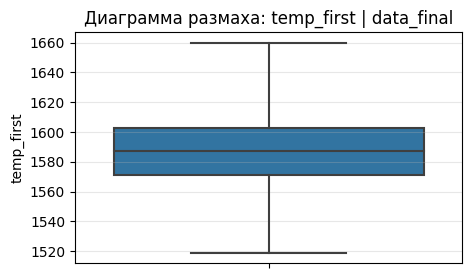

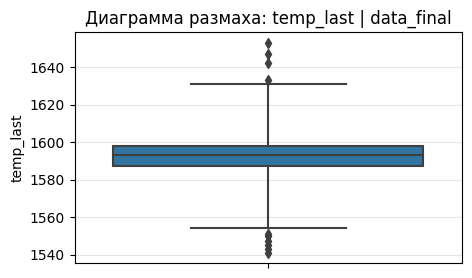

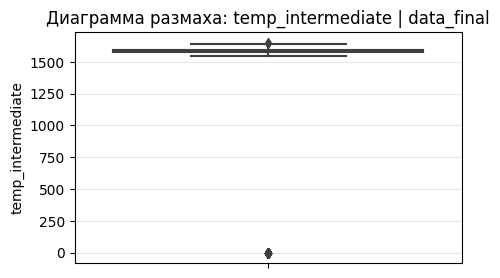

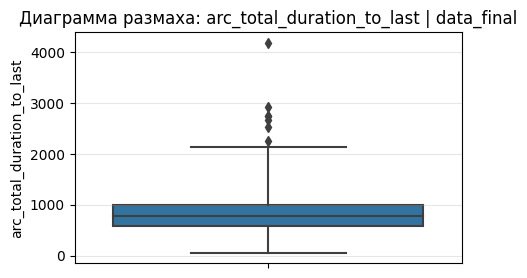

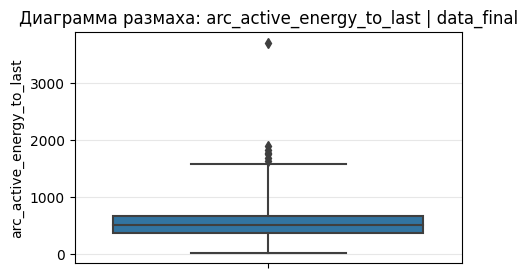

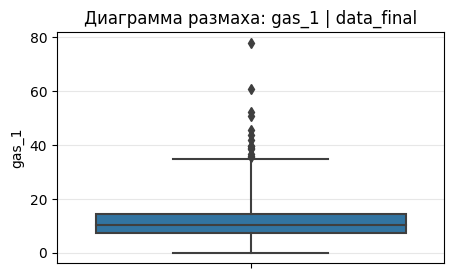

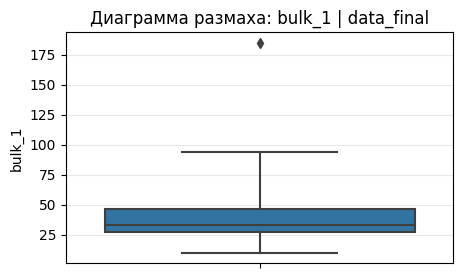

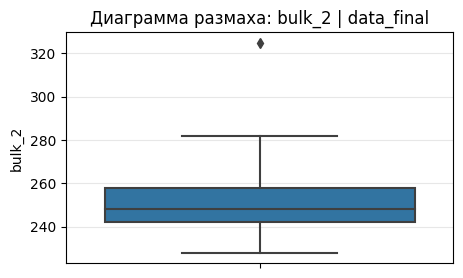

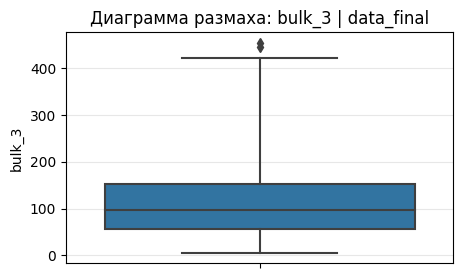

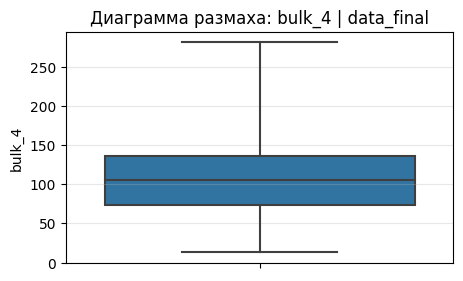

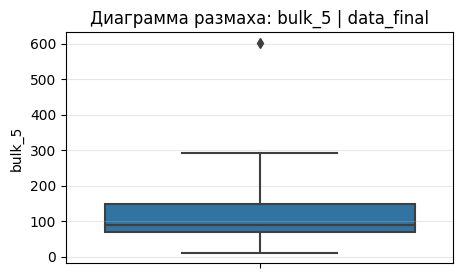

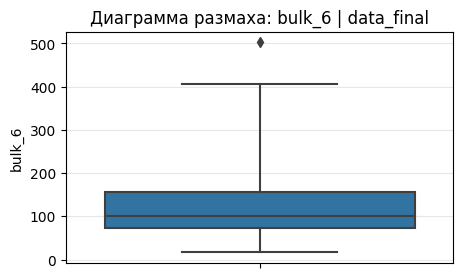

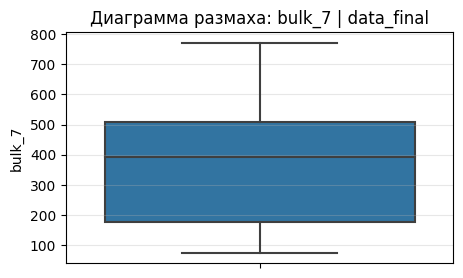

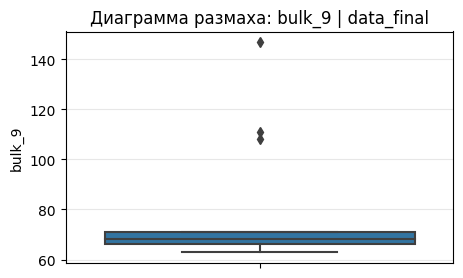

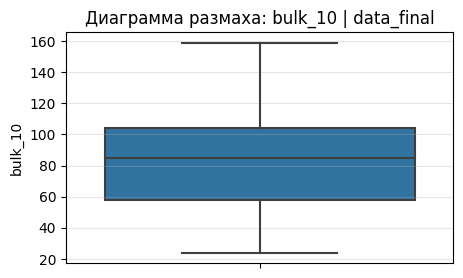

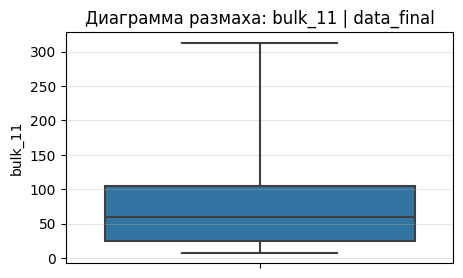

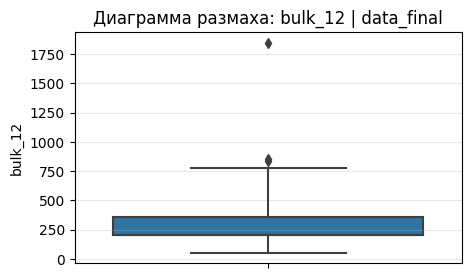

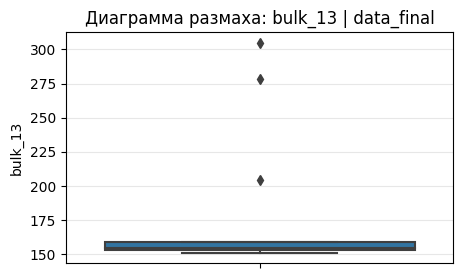

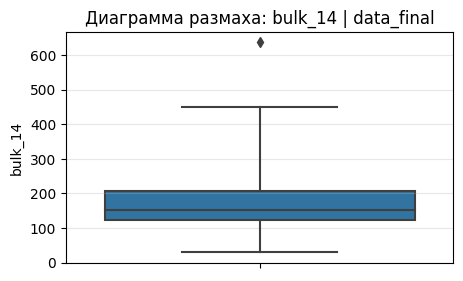

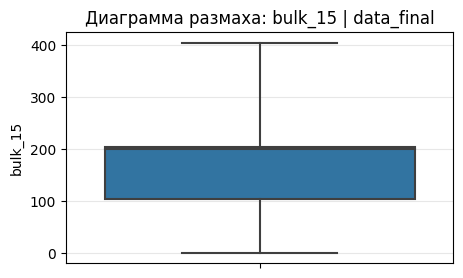

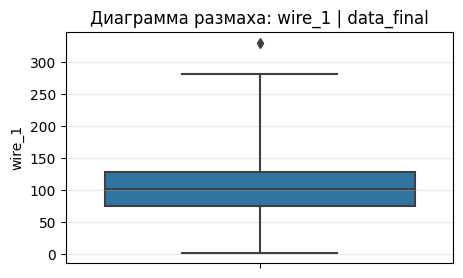

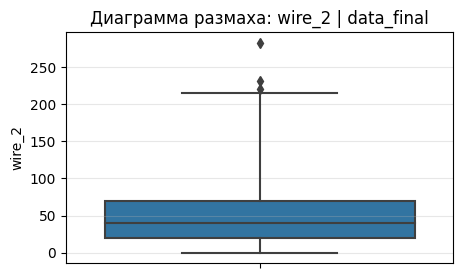

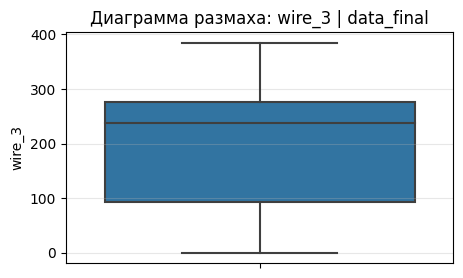

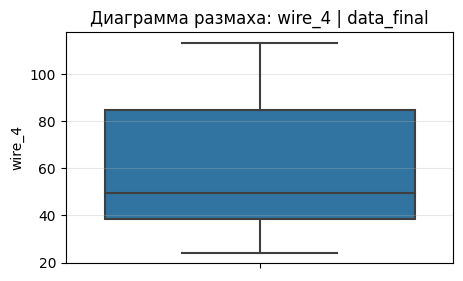

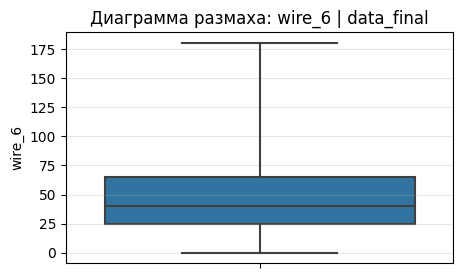

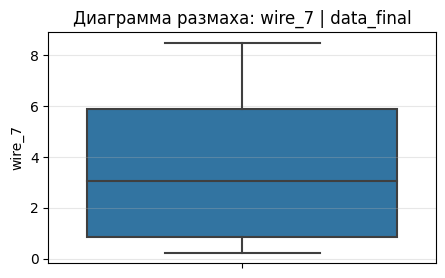

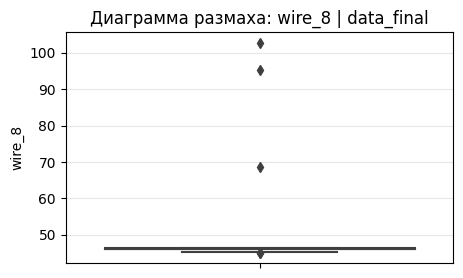

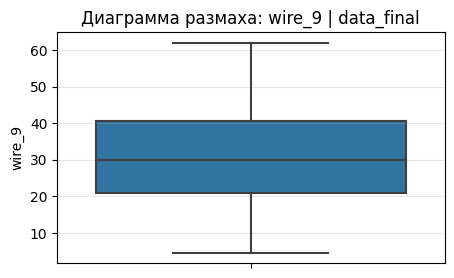

In [46]:
# Используем ранее написанную функицю
data_final_off_key = data_final.drop(columns=['key']).copy() # Удаляем столбец с ключами, бинарным признаков
numeric_cols = data_final_off_key.select_dtypes(include="number").columns # Выбираем только признаки с числовым типом данных

# Цикл по столбцам
for col in numeric_cols:
    plot_boxplot(
        df=data_final_off_key,
        column=col,
        dataset_name="data_final"
    )

#### Комментарий к графику

--

**Температурные признаки**

**`temp_first`, `temp_intermediate`, `temp_last`**

* Управляемые технологические параметры; экстремальные значения могут отражать нестандартные режимы, а не ошибки.
* Выбросы потенциально информативны, предпочтительна проверка допустимых диапазонов вместо удаления.

--

**Энергетика и длительность дуги**

**`arc_total_duration_to_last`, `arc_active_energy_to_last`, `data_gas`**

* Распределения с выраженной правосторонней асимметрией, типичной для временных и энергетических метрик.
* Выбросы являются частью реального процесса.

--

**Сыпучие материалы (Bulk)**

**`bulk_1` – `bulk_15`**

* Разреженные распределения с длинными хвостами; крупные значения соответствуют редким дозировкам.

--

**Проволока (Wire)**

**`wire_1` – `wire_9`**

* Более стабильные распределения по сравнению с bulk, но с отдельными экстремальными значениями.

--


### Гистограммы

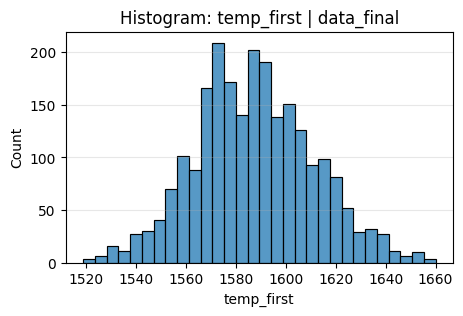

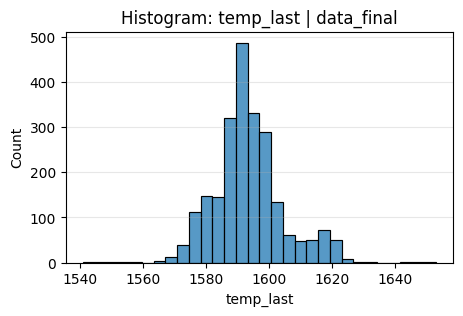

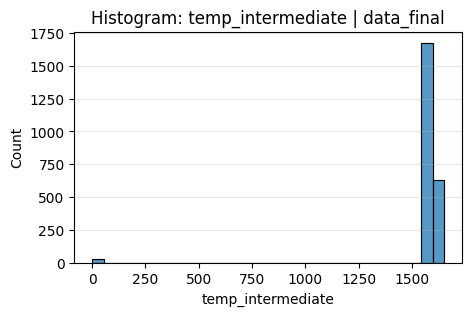

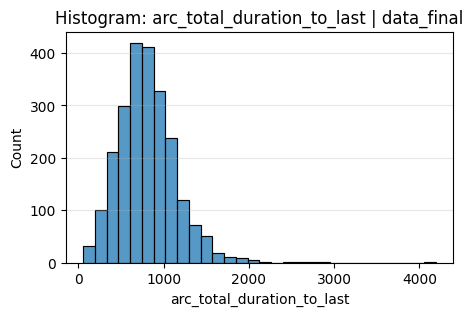

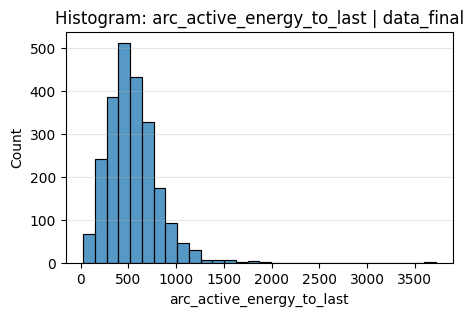

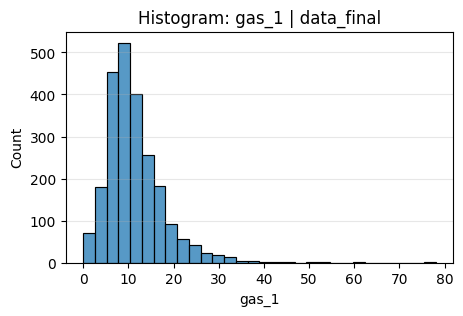

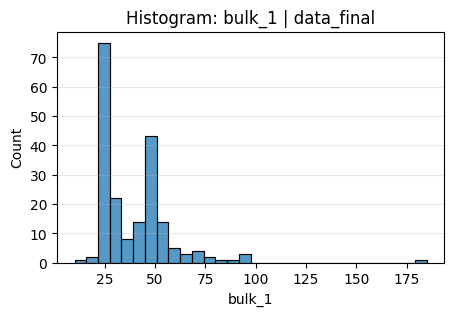

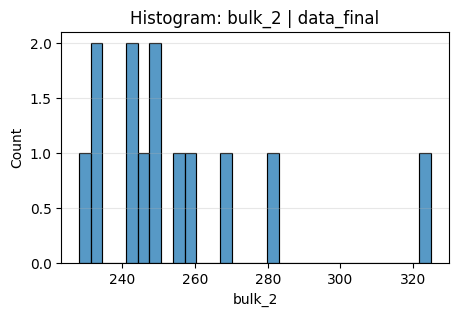

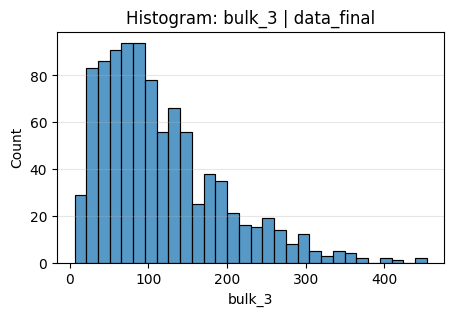

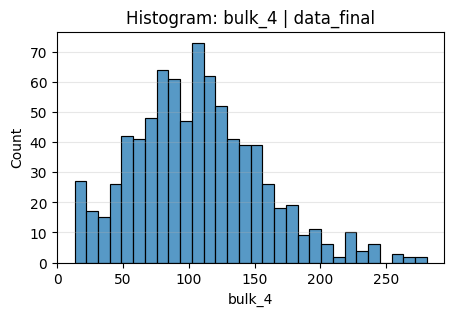

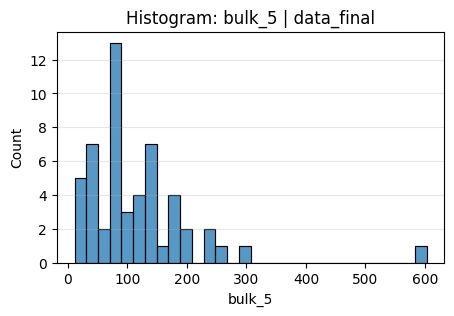

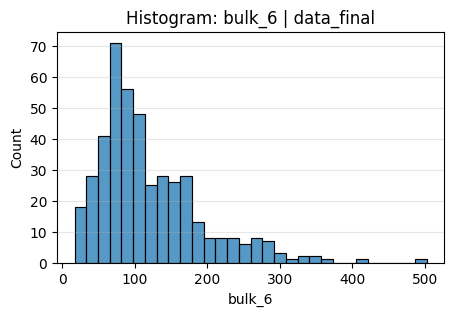

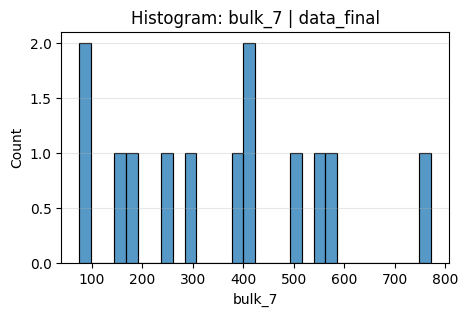

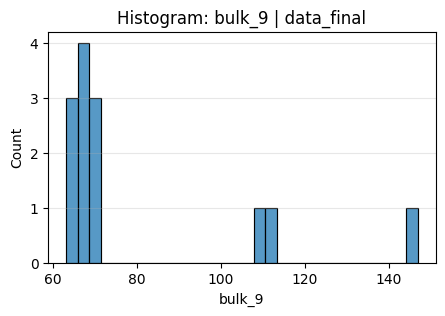

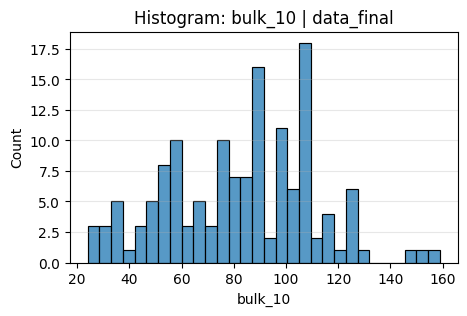

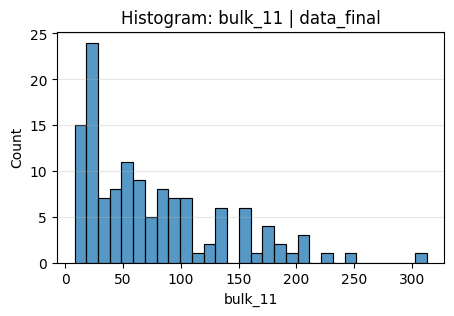

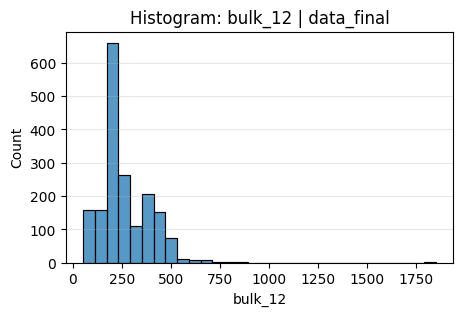

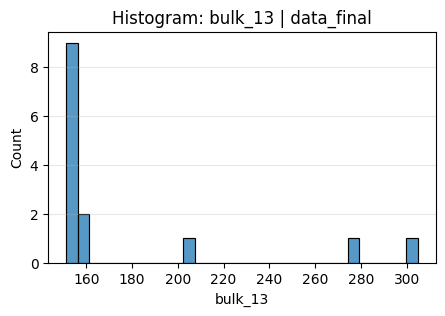

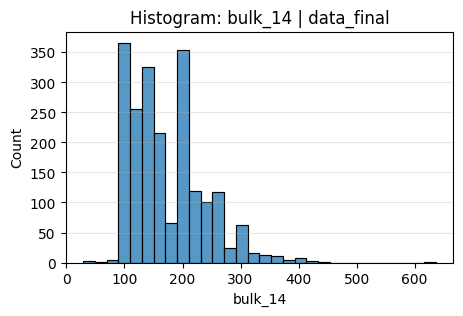

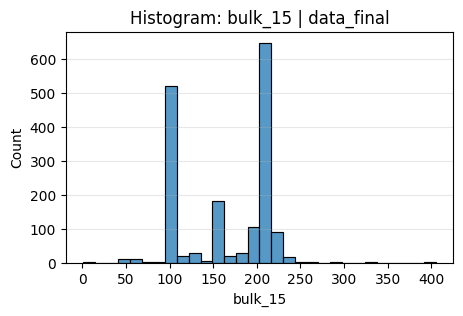

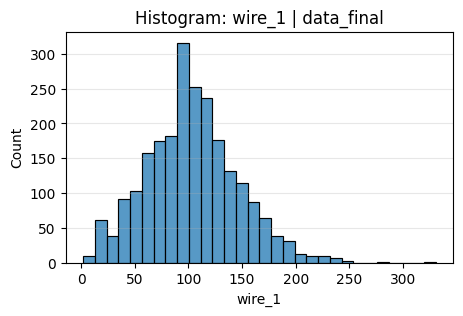

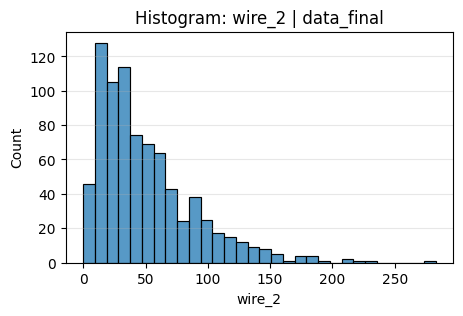

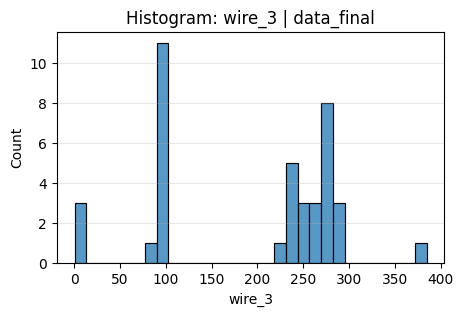

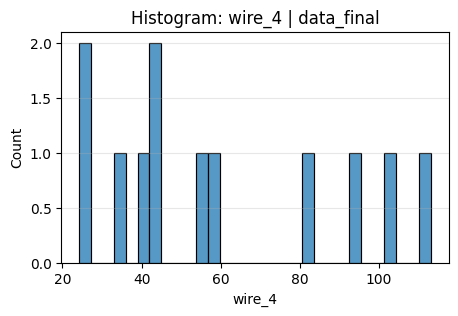

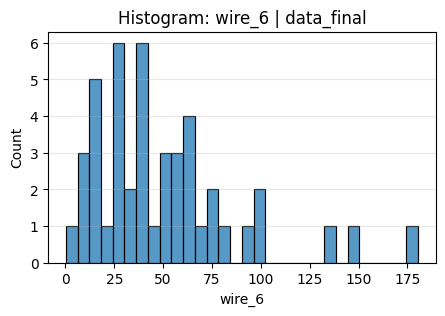

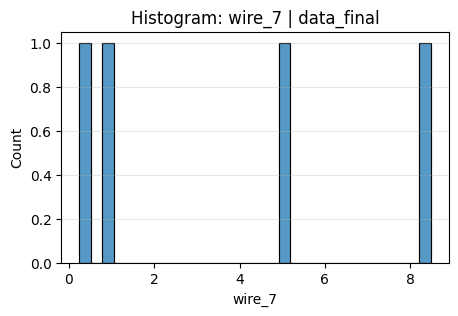

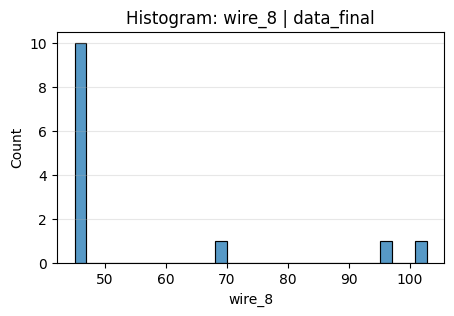

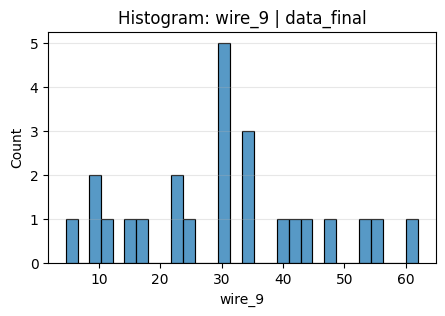

In [47]:
# Используем ранее написанную функицю
data_final_off_key = data_final.drop(columns=['key']).copy() # Удаляем столбец с ключами, бинарным признаком, дискретным признаком
numeric_cols = data_final_off_key.select_dtypes(include="number").columns # Выбираем только признаки с числовым типом данных

# Цикл по столбцам
for col in numeric_cols:
    plot_histogram(
        df=data_final_off_key,
        column=col,
        dataset_name="data_final"
    )

#### Комментарии к графику

**Температурные признаки**

**`temp_first`, `temp_intermediate`, `temp_last`**

* Распределения близки к нормальным с умеренной асимметрией; основная масса значений сосредоточена в узких диапазонах.
* `temp_first` содержит редкие аномально низкие значения, визуально отделённые от основной выборки.

--

**Длительность и энергия дуги**

**`arc_total_duration_to_last`, `arc_active_energy_to_last`**

* Выраженная правосторонняя асимметрия и длинные хвосты распределений.
* Экстремальные значения соответствуют редким энергоёмким процессам.

--

**Сыпучие материалы (Bulk) + gas**

**`bulk_1` – `bulk_15`, `gas`**

* Преобладают правосторонне-асимметричные и разреженные распределения с длинными хвостами.
* Для части признаков наблюдаются мультимодальность и редкие экстремальные дозировки.
* Большие значения визуально выглядят как выбросы, но вероятно отражают отдельные марки стали или корректирующие операции.

--

**Проволока (Wire)**

**`wire_1` – `wire_9`**

* Распределения менее разреженные, чем у bulk, но также асимметричные.
* Для ряда признаков (`wire_3`, `wire_4`, `wire_7`, `wire_8`, `wire_9`) крайне малое число наблюдений и высокая дискретность.
* Экстремальные значения присутствуют, но не выглядят случайным шумом.

--

### Промежуточные выводы

По результатам исследовательского анализа данных сводного датасета:
* температурные признаки имеют устойчивые распределения с умеренной асимметрией, при этом `temp_last` демонстрирует наименьшую дисперсию и может рассматриваться как стабильный таргет.
* признаки, связанные с дугой (`arc_total_duration_to_last`, `arc_active_energy_to_last`), характеризуются выраженной правосторонней асимметрией и широкими хвостами, что указывает на вариативность режимов плавки.
* большинство признаков `bulk_*` и `wire_*` являются разреженными, с большим числом нулей и редкими экстремальными значениями, отражающими эпизодическое использование материалов.

## Корреляционный анализ признаков

Для корреляционного анализа признаков воспользуемся Фик-матрицей, при этом из анализа исключим признаки с малым количеством наблюдений - меньше 100 наблюдений

In [48]:
# Формируем маску для фильтрации
MIN_NON_NULL = 100
mask = data_final.notna().sum() >= MIN_NON_NULL

# Фильтруем датасет от признаков с малым количеством наблюдений
data_final_filtered = data_final.loc[:, mask]

# Смотрим на результат
data_final_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   key                         2329 non-null   int64  
 1   temp_first                  2329 non-null   float64
 2   temp_last                   2329 non-null   float64
 3   temp_intermediate           2329 non-null   float64
 4   arc_total_duration_to_last  2329 non-null   float64
 5   arc_active_energy_to_last   2329 non-null   float64
 6   gas_1                       2329 non-null   float64
 7   bulk_1                      199 non-null    float64
 8   bulk_3                      960 non-null    float64
 9   bulk_4                      812 non-null    float64
 10  bulk_6                      438 non-null    float64
 11  bulk_10                     143 non-null    float64
 12  bulk_11                     130 non-null    float64
 13  bulk_12                     1812 

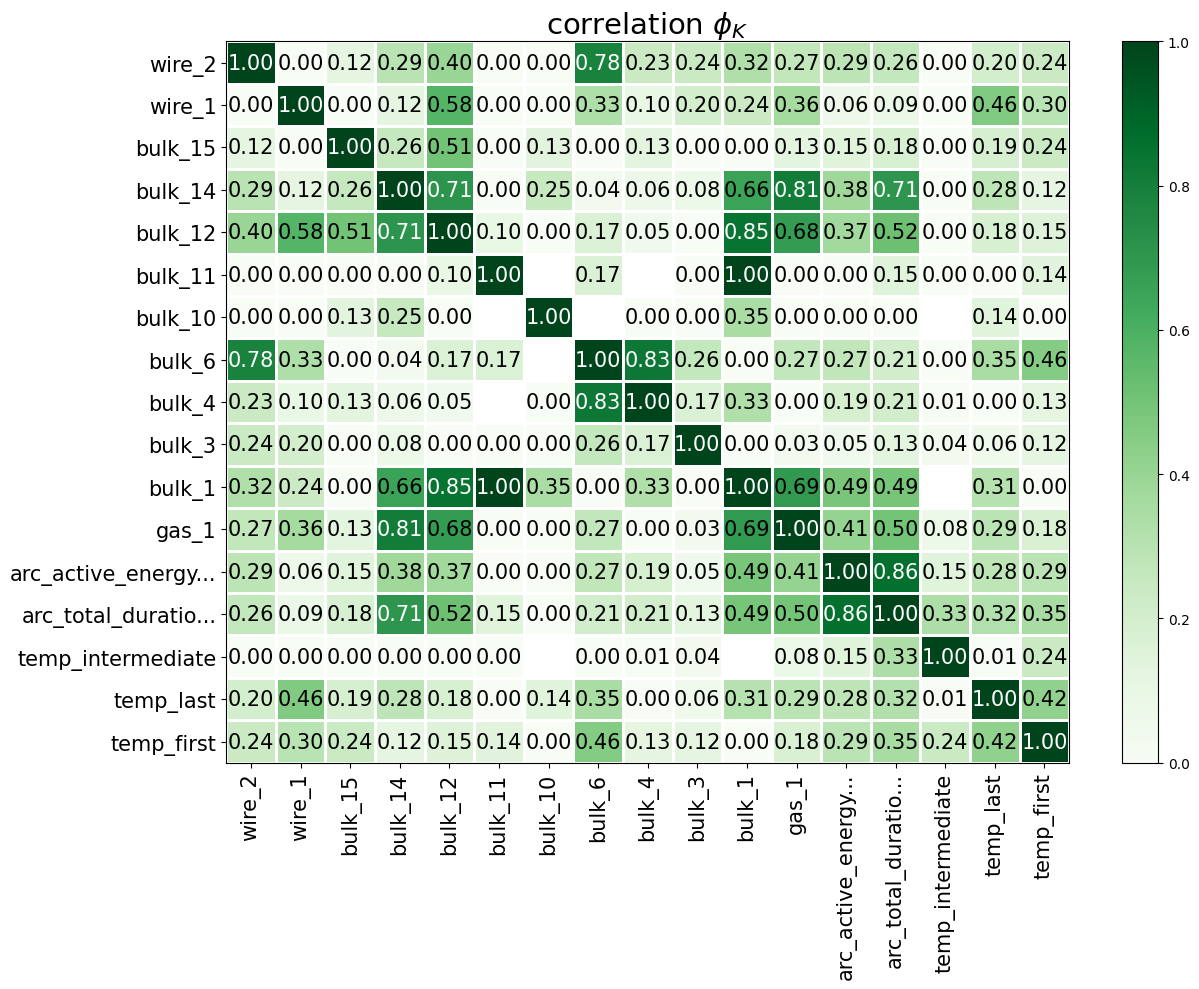

In [49]:
# Создаём список с наименованиями непрерывных признаков
feature_float_list = data_final_filtered.select_dtypes(include='float').columns.tolist()

# Создаем список с оставшимися признаками
feature_int_list = data_final_filtered.drop(columns=["key"]).select_dtypes(include='int').columns.tolist()

# Формируем конечный список признаков
cols = feature_float_list + feature_int_list

# Считаем корреляции на выборке
phik_overview_region_first = phik_matrix(data_final_filtered[cols], interval_cols=feature_float_list)

# Визуализируем матрицу корреляции
plot_correlation_matrix(
    phik_overview_region_first.values,
    x_labels=phik_overview_region_first.columns,
    y_labels=phik_overview_region_first.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(13, 10)
)

### Промежуточные выводы

* Обнаружена мультиколлениарность между признаками `bulk_1` и `bulk_11`, что может объясняться технологическим процессом - если добавляется первый материал, то обязательно добавляется второй
* На этапе подготовки данных к модели исключим признак `bulk_11`, т.к. он хуже объясняет таргет
* Важность признаков для таргета распределилась следующим образом:
    * 0.46 `wire_1`
    * 0.42 `temp_first`
    * 0.35 `bulk_6`
    * 0.32 `arc_total_duration_to_last`
    * 0.31 `bulk_1`    
    * Остальные признакие имеют коэффициент корреляции меньше 0.3

## Подготовка признаков для обучения модели

**Количественные признаки (16 признаков)**

Все используемые признаки являются **числовыми** и отражают либо температурные характеристики процесса, либо параметры электродугового нагрева, либо количество введённых легирующих материалов.

Для данных признаков рекомендуется **масштабирование** (например, `StandardScaler`), так как они измеряются в разных физических единицах и имеют существенно различающиеся диапазоны значений:

**Температурные признаки**

* `temp_first` — температура первого замера
* `temp_intermediate` — температура промежуточного замера
* `temp_last` — температура последнего замера

**Признаки электродугового нагрева**

* `arc_total_duration_to_last` — суммарная длительность нагрева дугой до последнего температурного замера
* `arc_active_energy_to_last` — энергия, полученная активной мощностью за время нагрева дуги до последнего замера

**Признаки легирующих добавок (сыпучие материалы) + gas**

* `bulk_1`
* `bulk_3`
* `bulk_4`
* `bulk_6`
* `bulk_10`
* `bulk_12`
* `bulk_14`
* `bulk_15`
* `gas_1`

**Признаки легирования проволокой**

* `wire_1`
* `wire_2`

Масштабирование позволит:

* обеспечить сопоставимость признаков при обучении моделей, чувствительных к масштабу (линейные модели, kNN, нейронные сети);
* стабилизировать процесс обучения и ускорить сходимость моделей.

**Работа с пропущенными значениями**

Для большинства признаков легирования характерна **большая доля пропусков**, что интерпретируется как **отсутствие подачи соответствующей добавки** в конкретной плавке.

Рекомендуемый подход:

* заменить пропуски на `0`, так как нулевое значение логически соответствует отсутствию внесения материала.

--

**Признаки, не входящие в модель (1 признак)**

Следующий признак исключается из обучения модели:

* `key` — технологический идентификатор плавки, не несущий прогностической информации и используемый исключительно для связки таблиц и группировки данных.
* `bulk_11` - в связи с наличием мультиколлениарности с признаком `bulk_1`

--

**Итог**

В модель подаются **15 числовых признаков**, прошедших:

* обработку пропусков (замена на ноль для признаков легирования);
* масштабирование.

Категориальные признаки в текущем датасете отсутствуют, поэтому методы кодирования (`OneHotEncoder` и аналоги) не применяются.

## Пайплайн модели

### Обучение модели

In [50]:
# ================== 1. Разделяем выборку ==================

# Разделяем выборку на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(
    data_final_filtered.drop(columns=["key", "bulk_11", "temp_last"], axis=1),
    data_final_filtered["temp_last"],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

In [51]:
# ================== 2. Определяем признаки ==================

# Создаем списки с названиями признаков
num_columns = X_train.select_dtypes(include='float').columns.tolist()

In [52]:
# ================== 3. Пайплайн обработки ==================

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("scaler", StandardScaler())
                    ])

# Создаём общий пайплан для подготовки данных
data_preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_columns)
    ]
)

In [53]:
# ================== 4. Конфигурация моделей ==================

models_config = {
    "DecisionTree": {
        "model": DecisionTreeRegressor(random_state=RANDOM_STATE),
        "params": {
            'model__max_depth': [None, 3, 5, 7, 9, 11],
            'model__min_samples_leaf': [1, 2, 3, 4, 5],
            'model__max_features': [None, 1, 2, 3, 5]
        }
    },

    "LightGBM": {
        "model": LGBMRegressor(random_state=RANDOM_STATE),
        "params": {
            'model__n_estimators': [100, 200],       # количество деревьев
            'model__learning_rate': [0.05, 0.1],  # шаг обучения
            'model__max_depth': [3, 5, 7, -1],      # глубина деревьев, -1 = без ограничения
        }
    },

    "CatBoost": {
        "model": CatBoostRegressor(random_state=RANDOM_STATE, verbose=0), # Без показа логов обучения
        "params": {
            'model__n_estimators': [200, 400],
            'model__learning_rate': [0.03, 0.1],
            'model__depth': [4, 6, 8]
        }
    }
}

In [54]:
# ================== 5. RandomizedSearchCV для каждой модели ==================

search_results = {}

for model_name, cfg in models_config.items():

    pipe = Pipeline([
        ("preprocessor", data_preprocessor),
        ("model", cfg["model"])
    ])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=cfg["params"],
        n_iter=10,
        cv=3,
        scoring="neg_mean_absolute_error",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    # Замер времени обучения
    t0 = time.time()
    search.fit(X_train, y_train)
    train_time = time.time() - t0

    search_results[model_name] = {
        "best_estimator": search.best_estimator_,
        "best_mae": abs(search.best_score_),
        "best_params": search.best_params_
    }

    print(f"\nМодель: {model_name}")
    print(f"MAE (CV): {np.abs(search.best_score_):.2f}")
    print(f"Лучшие параметры:")
    print(search.best_params_)
    print(f"Время обучения: {train_time:.2f}")

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is sla


Модель: DecisionTree
MAE (CV): 5.66
Лучшие параметры:
{'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': 3}
Время обучения: 0.73

Модель: LightGBM
MAE (CV): 4.54
Лучшие параметры:
{'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}
Время обучения: 0.91

Модель: CatBoost
MAE (CV): 4.54
Лучшие параметры:
{'model__n_estimators': 400, 'model__learning_rate': 0.03, 'model__depth': 6}
Время обучения: 9.53


### Тестирование лучшей модели

In [55]:
# ================== 6. Определение лучшей модели ==================

# Определим лучшую модель среди обученных
best_model_name = min(
    search_results,
    key=lambda x: search_results[x]["best_mae"]
)

best_model = search_results[best_model_name]["best_estimator"]

print("\nИТОГ:")
print("Лучшая модель:", best_model_name)
print(f'MAE:, {round(search_results[best_model_name]["best_mae"], 2)}')


ИТОГ:
Лучшая модель: LightGBM
MAE:, 4.54


In [56]:
# ================== 7. Оценка на тестовой выборке ==================

# Делаем предсказания на тестовой выборке
y_pred = best_model.predict(X_test)

# Считаем MAE на тесте
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Метрика MAE лучшей модели на тестовой выборке: {mae_test:.2f}')

Метрика MAE лучшей модели на тестовой выборке: 4.30


In [57]:
# ================== 8. Прогноз с помощью dummy_regressor ==================

# Инициализация Дамми-регрессора
dummy = DummyRegressor(strategy='mean')

# Обучение на тренировочных данных
dummy.fit(X_train, y_train)

# Прогноз модели на тестовой выборке
y_pred_dummy = dummy.predict(X_test)

# Расчет метрики MAE
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)

# Выводим результат
print(f"Dummy MAE: {mae_dummy:.2f}")

Dummy MAE: 7.62


### Промежуточные выводы

* Модель с лучшей метрикой MAE это LGBMRegressor
* Метрика MAE на тестовой выборке: 4.30, что лучше уровня, заданного бизнесом, и выше уровня случайного прогнозирования (7.62)

## Анализ и интерпретация результатов работы лучшей модели

### Анализ остатков лучшей модели

Среднее остатка: 0
Стандартное отклонение остатков: 6
Минимум: -42
Максимум: 24


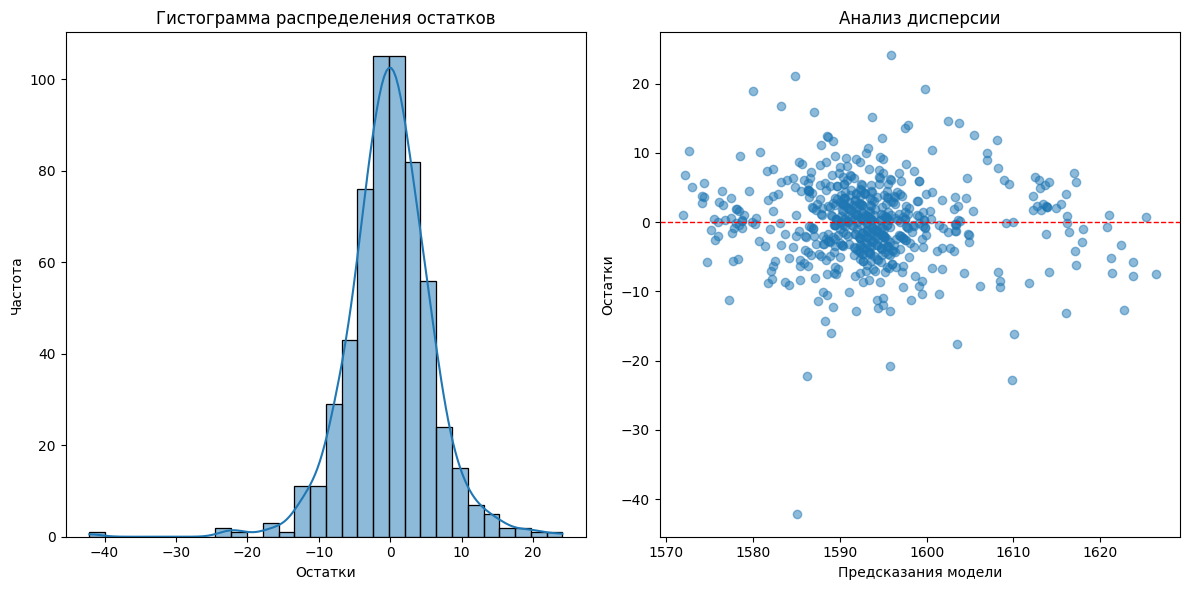

In [58]:
# 1. Рассчитаем остатки
residuals = y_test.values - y_pred

# 2. Статистики остатков
print("Среднее остатка:", round(np.mean(residuals)))
print("Стандартное отклонение остатков:", round(np.std(residuals)))
print("Минимум:", round(np.min(residuals)))
print("Максимум:", round(np.max(residuals)))

# 3. Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Гистограмма распределения остатков
sns.histplot(residuals, bins=30, kde=True, ax=axes[0])
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частота')

# Диаграмма рассеяния остатков против предсказаний
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

plt.tight_layout()
plt.show()

#### Промежуточные выводы

* Распределение остатков близко к симметричному унимодальному без выраженного смещения
* Дисперсия остатков НЕравномерная, предсказания имеют разброс (1570-1630) ввиду наличия выбросов в значениях признаков, обусловленных технологическом процессом

### Анализ важности признаков по методу SHAP

#### Подготовка данных

In [59]:
# Предподготовка
preprocessor = best_model.named_steps["preprocessor"]
model = best_model.named_steps["model"]

# Смотрим на результат
print(preprocessor)
print(model)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['temp_first', 'temp_intermediate',
                                  'arc_total_duration_to_last',
                                  'arc_active_energy_to_last', 'gas_1',
                                  'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6',
                                  'bulk_10', 'bulk_12', 'bulk_14', 'bulk_15',
                                  'wire_1', 'wire_2'])])
LGBMRegressor(max_depth=5, random_state=120126)


In [60]:
# Трансформируем данные
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Выгружаем наименования признаков
feature_names = num_columns

# Смотрим на результат
print(feature_names)

['temp_first', 'temp_intermediate', 'arc_total_duration_to_last', 'arc_active_energy_to_last', 'gas_1', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_10', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2']


#### Permuatation importance

In [61]:
# Проверка размерности
assert X_train_transformed.shape[1] == len(feature_names)

In [62]:
# Инициализация метод
perm = permutation_importance(
    best_model,
    X_test, y_test,
    scoring="neg_mean_absolute_error",
    n_repeats=15,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Формируем датафрейм
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False)

# Смотрим результат
importance_df.head(15)

,feature,importance,std
1,temp_intermediate,4.97,0.16
2,arc_total_duration_to_last,1.86,0.15
4,gas_1,0.22,0.04
8,bulk_6,0.20,0.04
14,wire_2,0.14,0.03
0,temp_first,0.14,0.05
5,bulk_1,0.14,0.04
3,arc_active_energy_to_last,0.13,0.03
13,wire_1,0.10,0.04
11,bulk_14,0.05,0.03


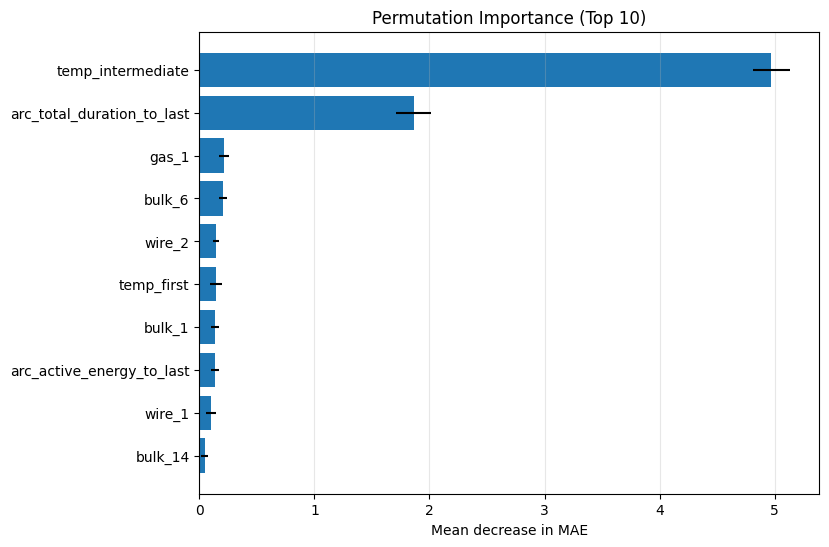

In [63]:
# Настраиваем параметры для вывода 15 влиятельных признаков
TOP_N = 10
plot_df = importance_df.head(TOP_N).sort_values("importance")

# Параметры графика
plt.barh(plot_df["feature"], plot_df["importance"], xerr=plot_df["std"])
plt.xlabel("Mean decrease in MAE")
plt.title("Permutation Importance (Top 10)")
plt.grid(axis="x", alpha=0.3)

# Вывод на экран
plt.show()

#### SHAP

##### График общей важности признаков

In [64]:
# Формирование тренировочных данных для графика
explainer = shap.Explainer(model, X_train_transformed, feature_names=feature_names)

# Подготовка значений тестовых данных
shap_values = explainer(X_test_transformed)

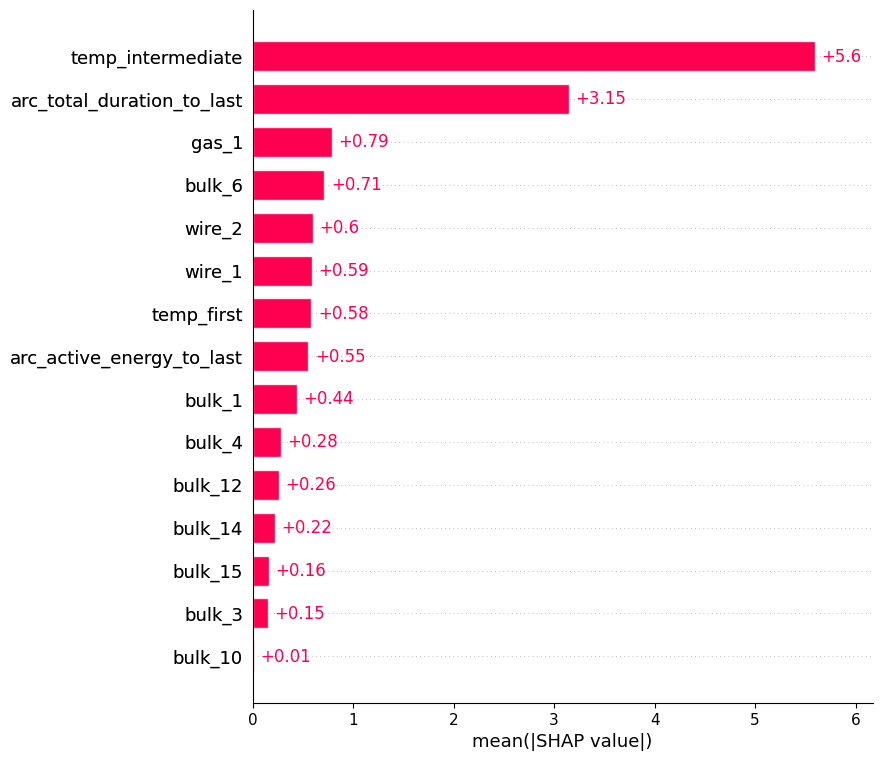

In [65]:
# Строим график shap
shap.plots.bar(shap_values, max_display=15, show=False)
plt.show()

##### График важности признаков Beeswarm

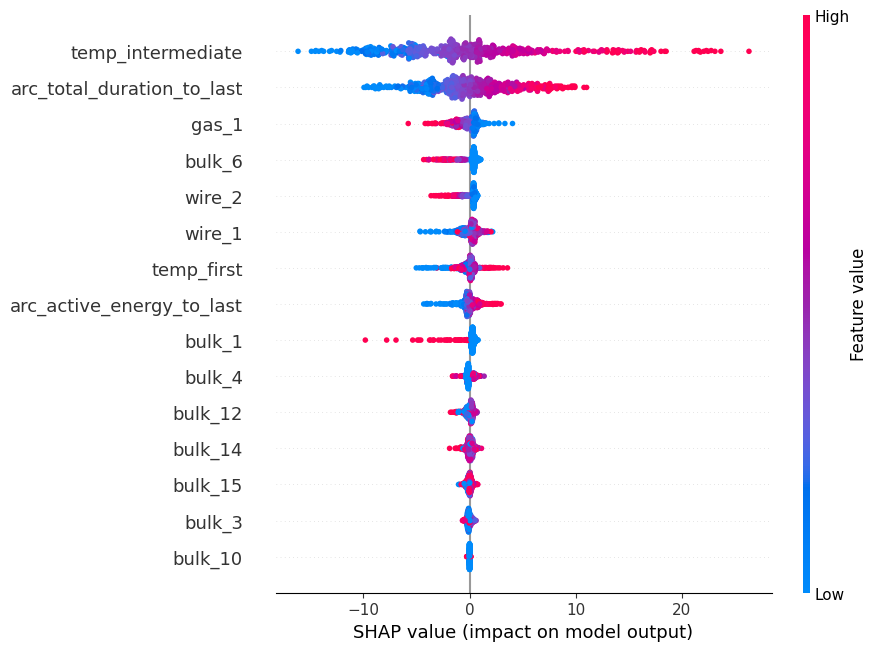

In [66]:
# Построим график влияния признаков на каждое предсказание модели
shap.plots.beeswarm(shap_values, max_display=15)

#### Промежуточные выводы

**Ключевые инсайты и рекомендации**

**1. Промежуточная температура — главный драйвер**

**Инсайт:** `temp_intermediate` даёт максимальный вклад в точность прогноза.
**Рекомендация:** использовать промежуточный замер как **ранний индикатор отклонений** и точку принятия решений по корректировке режима нагрева.

--

**2. Длительность дуги важнее энергетических метрик**

**Инсайт:** `arc_total_duration_to_last` влияет сильнее, чем `arc_active_energy_to_last`.
**Рекомендация:** фокусироваться на управлении **временем нагрева**, упрощая контроль и снижая сложность регламентов.

--

**3. Газ и легирующие добавки — вторичный эффект**

**Инсайт:** влияние газа и bulk/wire проявляется локально и зависит от контекста.
**Рекомендация:** не использовать их как основные управляющие параметры, а применять для **тонкой корректировки** процесса.

--

**4. Часть признаков не влияет на результат**

**Инсайт:** ряд bulk-признаков имеет близкую к нулю важность.
**Рекомендация:** рассмотреть **исключение неинформативных признаков** для упрощения модели и повышения устойчивости.

--

**5. Модель пригодна для рекомендательного режима**

**Инсайт:** ключевые факторы процесса интерпретируемы и согласованы между методами анализа.
**Рекомендация:** использовать модель в режиме **поддержки решений** без повышения технологических рисков.

## Общий итог

**Общая информация по датасету:**

* `data_arc`: 4 признака, 14 876 строк, без пропущенных значений, необходимо скорректировать тип данных для временных признаков
* `data_bulk`, `data_bulk_time`: 15 признаков, 3 129 строк, есть пропущенные значения
* `data_gas`: 1 признак, 3 239 строк, без пропущенных значений
* `data_temp`: 2 признака, 18 092 строки, есть пропущенные значения
* `data_wire`, `data_wire_time`: 9 признаков, 3 081 строка, есть пропущенные значения
* Необходимо привести наименования признаков к виду snake_case для удобства анализа
* Необходимо перевести имена признаков на латинские буквы

--

**Предобработка данных**

* Имена признаков приведены к виду snake_case и переведены на английский язык
* Тип данных временных признаков приведен в соответствие
* Явные дубликаты отсутствуют
* Выявлены пропущенные значения - к обработке после объединения датасетов

--

**Исследовательский анализ данных (до объединения)**

* Аномальное отрицательное значение реактивной мощности обработано

* По датасету **`data_temp`** признак `temperature` непрерывный, узкий диапазон значений, одномодальный
* По датасету **`data_arc`** по признаками `active_power`, `reactive_power`
    * Выраженная правосторонняя асимметрия
    * Значимая вариативность
* По датасету **`data_bulk`** можем разделить признаки на следующие группы:
    * Количественные дозируемые (основные рабочие): `bulk_1`, `bulk_3`, `bulk_4`, `bulk_6`, `bulk_10`, `bulk_11`, `bulk_12`, `bulk_14`
        * Выраженная правосторонняя асимметрия
        * Значимая вариативность
    * Режимные (узкие по значениям): `bulk_2`
        * Очень мало наблюдений
    * Редкие дискретные с экстремальными режимами: `bulk_5`, `bulk_7`, `bulk_9`, `bulk_13`
        * Сильная разреженность
        * Мало ненулевых значений
    * Мультимодальные дозы: `bulk_15`
        * Чётко выраженные пики (примерно около значений 100 и 200)
        * Провал между режимами
    * Почти константные: `bulk_8` **(к удалению после объединения датасетов)**
* По датасету **`data_wire`** следующее распределение признаков:
    * Количественные признаки (асимметричные): `wire_1`, `wire_2`, `wire_6`
    * Мультимодальные (отчётливые пики, мало число наблюдений): `wire_3`
    * Редкие, разреженные: `wire_4`, `wire_7`, `wire_8`, `wire_9`
    * Почти константные: `wire_5` **(к удалению после объединения датасетов)**

**Трансформация признаков**

* Выполнена трансформация признакова в датасетах `data_temp` (якорный датасет), `data_arc` подготовки датасетов к объединению
* В датасете `data_temp` сформированы следующие признаки:
    * `temp_first` - температура при первом замере
    * `temp_last` - температура при крайнем замере **(таргет)**
    * `temp_intermediate` - медианная температура промежуточных замеров, не включая первый и крайний замеры
* В датасете `data_arc` сформированы дополнительные признаки:
    * `arc_total_duration_to_last` - суммарное время активной работы дуги до последнего замера температуры
    * `arc_active_energy_to_last` - величина, характеризующая накопленную интенсивность активного электродугового воздействия за все интервалы нагрева до момента последнего замера температуры
* Сформирован сводный датасет на основе следующих:
    * `data_temp`
    * `data_arc`
    * `data_bulk`
    * `data_wire`
    * `data_gas`
* Следующие датасеты исключены из анализа, т.к. задача не требует работу с временным рядом:
    * `data_bulk_time`
    * `data_wire_time`
    * Исключены временные признаки из датасета `data_temp`
* Также исключены следующие признаки ввиду наличия всего 1 наблюдения по ним:
    * `wire_5`
    * `bulk_8`

--

**Исследовательский анализ данных (после объединения)**

* температурные признаки имеют устойчивые распределения с умеренной асимметрией, при этом `temp_last` демонстрирует наименьшую дисперсию и может рассматриваться как стабильный таргет.
* признаки, связанные с дугой (`arc_total_duration_to_last`, `arc_active_energy_to_last`), характеризуются выраженной правосторонней асимметрией и широкими хвостами, что указывает на вариативность режимов плавки.
* большинство признаков `bulk_*` и `wire_*` являются разреженными, с большим числом нулей и редкими экстремальными значениями, отражающими эпизодическое использование материалов.

--

**Корреляционный анализ данных**

* Обнаружена мультиколлениарность между признаками `bulk_1` и `bulk_11`, что может объясняться технологическим процессом - если добавляется первый материал, то обязательно добавляется второй
* На этапе подготовки данных к модели исключим признак `bulk_11`, т.к. он хуже объясняет таргет
    * 0.46 `wire_1`
    * 0.42 `temp_first`
    * 0.35 `bulk_6`
    * 0.32 `arc_total_duration_to_last`
    * 0.31 `bulk_1`    
    * Остальные признакие имеют коэффициент корреляции меньше 0.3

--

**Подготовка данных для загрузки в модель МО**

* Все используемые признаки являются **числовыми** и отражают либо температурные характеристики процесса, либо параметры электродугового нагрева, либо количество введённых легирующих материалов
* Для данных признаков рекомендуется **масштабирование** (`StandardScaler`), так как они измеряются в разных физических единицах и имеют существенно различающиеся диапазоны значений

--

**Итоги построения модели**

* Модель с лучшей метрикой MAE это LGBMRegressor
* Метрика MAE на тестовой выборке: 4.30, что лучше уровня, заданного бизнесом, и выше уровня случайного прогнозирования (7.62)
* Распределение остатков близко к симметричному унимодальному без выраженного смещения
* Дисперсия остатков НЕравномерная, предсказания имеют разброс (1570-1630) ввиду наличия выбросов в значениях признаков, обусловленных технологическом процессом

**Ключевые инсайты и рекомендации**

**1. Промежуточная температура — главный драйвер**

**Инсайт:** `temp_intermediate` даёт максимальный вклад в точность прогноза.
**Рекомендация:** использовать промежуточный замер как **ранний индикатор отклонений** и точку принятия решений по корректировке режима нагрева.

--

**2. Длительность дуги важнее энергетических метрик**

**Инсайт:** `arc_total_duration_to_last` влияет сильнее, чем `arc_active_energy_to_last`.
**Рекомендация:** фокусироваться на управлении **временем нагрева**, упрощая контроль и снижая сложность регламентов.

--

**3. Газ и легирующие добавки — вторичный эффект**

**Инсайт:** влияние газа и bulk/wire проявляется локально и зависит от контекста.
**Рекомендация:** не использовать их как основные управляющие параметры, а применять для **тонкой корректировки** процесса.

--

**4. Часть признаков не влияет на результат**

**Инсайт:** ряд bulk-признаков имеет близкую к нулю важность.
**Рекомендация:** рассмотреть **исключение неинформативных признаков** для упрощения модели и повышения устойчивости.

--

**5. Модель пригодна для рекомендательного режима**

**Инсайт:** ключевые факторы процесса интерпретируемы и согласованы между методами анализа.
**Рекомендация:** использовать модель в режиме **поддержки решений** без повышения технологических рисков.